# **Global Spotify Trends: Regional & Temporal Data Mining Analysis**
#### **Maya Shah and Gabe Wild**
---
This notebook explores how we deconstructed global music consumption data on Spotify from 2017-2021 to effectively cluster songs based off of their audio features and discover how global preferences change over time.


[Final Submission Folder](https://drive.google.com/drive/folders/1i20P67h-xaKKs7pWbLzNx6A7xBnFN_7L?usp=sharing) (Slides, Charts, Colab etc.)


## **Step 0. Set-Up**
---
This step prepares the colab for our work below. It involves:
- **Install Dependencies**
- **Import Libraries**
- **Define Global Constants**
- **Import Datasets**: Spotify Top 200 charts by <day, region> from 2017-2021 and audio features for each song in the Top 200 charts from this time frame.

In [ ]:
!pip install opendatasets
!pip install pandas
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 50.1 MB/s eta 0:00:00


In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import math
from gensim.models import Word2Vec
import sys

# Scikit-learn imports
from scipy import stats
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.spatial.distance import cosine

# UMAP/HDBSCAN imports
import umap.umap_ as umap
import warnings

# Plotly for interactive map
import plotly.express as px

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# --- Global Constants and Mapping Dictionaries ---

# Columns containing the audio features used for clustering
FEATURE_COLS = [
    'danceability', 'energy', 'speechiness', 'acousticness',
    'instrumentalness', 'liveness', 'valence', 'loudness', 'tempo'
]
# Cluster labels for visualization and analysis
CLUSTER_NAMES = {
    0: 'Cluster 1',
    1: 'Cluster 2',
    2: 'Cluster 3',
    3: 'Cluster 4'
}
# Order for plotting clusters
GLOBAL_CLUSTER_ORDER = sorted(CLUSTER_NAMES.keys())

# Region mapping dictionary for Super Region analysis
REGION_MAPPING_DICT = {
    'North America': ['Canada', 'United States'],
    'Latin America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Costa Rica', 'Dominican Republic', 'Ecuador', 'El Salvador', 'Guatemala', 'Honduras', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Uruguay'],
    'Western Europe': ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Iceland', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom'],
    'Central & Eastern Europe': ['Bulgaria', 'Czech Republic', 'Estonia', 'Greece', 'Hungary', 'Latvia', 'Lithuania', 'Poland', 'Romania', 'Russia', 'Slovakia', 'Ukraine'],
    'Middle East & North Africa (MENA)': ['Egypt', 'Israel', 'Morocco', 'Saudi Arabia', 'Turkey', 'United Arab Emirates'],
    'East & Southeast Asia': ['Hong Kong', 'India', 'Indonesia', 'Japan', 'Malaysia', 'Philippines', 'Singapore', 'South Korea', 'Taiwan', 'Thailand', 'Vietnam'],
    'Oceania & Australasia': ['Australia', 'New Zealand'],
    'Sub-Saharan Africa': ['South Africa'],
    'Global': ['Global']
}

# ISO code mapping for choropleth map
ISO_MAP_DATA = {
    'Argentina': 'ARG', 'Australia': 'AUS', 'Austria': 'AUT', 'Belgium': 'BEL', 'Bolivia': 'BOL', 'Brazil': 'BRA', 'Bulgaria': 'BGR', 'Canada': 'CAN', 'Chile': 'CHL', 'Colombia': 'COL', 'Costa Rica': 'CRI', 'Czech Republic': 'CZE', 'Denmark': 'DNK', 'Dominican Republic': 'DOM', 'Ecuador': 'ECU', 'Egypt': 'EGY', 'El Salvador': 'SLV', 'Estonia': 'EST', 'Finland': 'FIN', 'France': 'FRA', 'Germany': 'DEU', 'Greece': 'GRC', 'Guatemala': 'GTM', 'Honduras': 'HND', 'Hong Kong': 'HKG', 'Hungary': 'HUN', 'Iceland': 'ISL', 'India': 'IND', 'Indonesia': 'IDN', 'Ireland': 'IRL', 'Israel': 'ISR', 'Italy': 'ITA', 'Japan': 'JPN', 'Latvia': 'LVA', 'Lithuania': 'LTU', 'Luxembourg': 'LUX', 'Malaysia': 'MYS', 'Mexico': 'MEX', 'Morocco': 'MAR', 'Netherlands': 'NLD', 'New Zealand': 'NZL', 'Nicaragua': 'NIC', 'Norway': 'NOR', 'Panama': 'PAN', 'Paraguay': 'PRY', 'Peru': 'PER', 'Philippines': 'PHL', 'Poland': 'POL', 'Portugal': 'PRT', 'Romania': 'ROU', 'Russia': 'RUS', 'Saudi Arabia': 'SAU', 'Singapore': 'SGP', 'Slovakia': 'SVK', 'South Africa': 'ZAF', 'South Korea': 'KOR', 'Spain': 'ESP', 'Sweden': 'SWE', 'Switzerland': 'CHE', 'Taiwan': 'TWN', 'Thailand': 'THA', 'Turkey': 'TUR', 'Ukraine': 'UKR', 'United Arab Emirates': 'ARE', 'United Kingdom': 'GBR', 'United States': 'USA', 'Uruguay': 'URY', 'Vietnam': 'VNM'
}
ISO_MAP_DF = pd.DataFrame(
    list(ISO_MAP_DATA.items()),
    columns=['region', 'iso_alpha']
)

SHARED_COLOR_MAP = {
    '0': '#636EFA',   # Blue
    '1': '#EF553B',   # Orange
    '2': '#00CC96',   # Green
    '3': '#AB63FA',   # Purple
    '-1': 'lightgray' # Noise Cluster
}

In [ ]:
def setup_and_load_data(kaggle_username, kaggle_key):
    """Installs dependencies, downloads datasets, and loads them into DataFrames."""
    print("--- 0. Setup and Data Loading ---")

    try:
        import google.colab.userdata
    except ImportError:
        pass

    # Download datasets
    spotify_charts_url = 'https://www.kaggle.com/datasets/dhruvildave/spotify-charts'
    spotify_audio_features_url = 'https://www.kaggle.com/datasets/julianoorlandi/spotify-top-songs-and-audio-features'

    od.download(spotify_charts_url, username=kaggle_username, key=kaggle_key)
    od.download(spotify_audio_features_url, username=kaggle_username, key=kaggle_key)

    # Load CSV files
    charts_df = pd.read_csv('./spotify-charts/charts.csv')
    audio_features_df = pd.read_csv('./spotify-top-songs-and-audio-features/spotify_top_songs_audio_features.csv')

    print(f"Charts DataFrame loaded: {charts_df.shape}")
    print(f"Audio Features DataFrame loaded: {audio_features_df.shape}")
    return charts_df, audio_features_df

In [ ]:
try:
  from google.colab import userdata
  kaggle_username = "mayashah.tamu"
  kaggle_key = userdata.get('KAGGLE_API_TOKEN')
except ImportError:
  kaggle_username = "mayashah.tamu"
  kaggle_key = "YOUR_KAGGLE_KEY_HERE"

# --- 0. Setup and Data Loading ---
charts_df, audio_features_df = setup_and_load_data(kaggle_username, kaggle_key)

# 0. Output Initial DataFrame Heads
print("\n" + "="*50)
print("INITIAL DATAFRAME HEADS (RAW)")
print("="*50)
print("\nCharts DataFrame (charts_df) Head:")
display(charts_df.head())
print("\nAudio Features DataFrame (audio_features_df) Head:")
display(audio_features_df.head())
print("-" * 50)

--- 0. Setup and Data Loading ---
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mayashah.tamu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dhruvildave/spotify-charts


100%|██████████| 945M/945M [00:07<00:00, 131MB/s] 



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mayashah.tamu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/julianoorlandi/spotify-top-songs-and-audio-features


100%|██████████| 526k/526k [00:00<00:00, 754MB/s]

Charts DataFrame loaded: (26173514, 9)
Audio Features DataFrame loaded: (6513, 19)

INITIAL DATAFRAME HEADS (RAW)

Charts DataFrame (charts_df) Head:


title  rank        date  \
0      Chantaje (feat. Maluma)     1  2017-01-01   
1  Vente Pa' Ca (feat. Maluma)     2  2017-01-01   
2   Reggaetón Lento (Bailemos)     3  2017-01-01   
3                       Safari     4  2017-01-01   
4                  Shaky Shaky     5  2017-01-01   

                                  artist  \
0                                Shakira   
1                           Ricky Martin   
2                                   CNCO   
3  J Balvin, Pharrell Williams, BIA, Sky   
4                           Daddy Yankee   

                                                 url     region   chart  \
0  https://open.spotify.com/track/6mICuAdrwEjh6Y6...  Argentina  top200   
1  https://open.spotify.com/track/7DM4BPaS7uofFul...  Argentina  top200   
2  https://open.spotify.com/track/3AEZUABDXNtecAO...  Argentina  top200   
3  https://open.spotify.com/track/6rQSrBHf7HlZjtc...  Argentina  top200   
4  https://open.spotify.com/track/58IL315gMSTD37D...  Argentina  top200   

           trend   streams  
0  SAME_POSITION  253019.0  
1        MOVE_UP  223988.0  
2      MOVE_DOWN  210943.0  
3  SAME_POSITION  173865.0  
4        MOVE_UP  153956.0


Audio Features DataFrame (audio_features_df) Head:


id                artist_names  \
0  000xQL6tZNLJzIrtIgxqSl         ZAYN, PARTYNEXTDOOR   
1  003eoIwxETJujVWmNFMoZy                Alessia Cara   
2  003vvx7Niy0yvhvHt4a68B                 The Killers   
3  00B7TZ0Xawar6NZ00JFomN  Cardi B, Chance the Rapper   
4  00Blm7zeNqgYLPtW6zg8cj     Post Malone, The Weeknd   

                             track_name              source    key   mode  \
0  Still Got Time (feat. PARTYNEXTDOOR)   RCA Records Label      G  Major   
1                         Growing Pains  Def Jam Recordings  C#/Db  Minor   
2                        Mr. Brightside      Island Records  C#/Db  Major   
3   Best Life (feat. Chance The Rapper)        Atlantic/KSR      A  Major   
4       One Right Now (with The Weeknd)    Republic Records  C#/Db  Major   

  time_signature  danceability  energy  speechiness  acousticness  \
0        4 beats         0.748   0.627       0.0639       0.13100   
1        4 beats         0.353   0.755       0.7330       0.08220   
2        4 beats         0.352   0.911       0.0747       0.00121   
3        4 beats         0.620   0.625       0.5530       0.28700   
4        4 beats         0.687   0.781       0.0530       0.03610   

   instrumentalness  liveness  valence  loudness    tempo  duration_ms  \
0               0.0    0.0852    0.524    -6.029  120.963       188491   
1               0.0    0.3900    0.437    -6.276  191.153       193680   
2               0.0    0.0995    0.236    -5.230  148.033       222973   
3               0.0    0.3140    0.665    -7.438  167.911       284856   
4               0.0    0.0755    0.688    -4.806   97.014       193507   

   weeks_on_chart    streams  
0              17  107527761  
1               2    9944865  
2             125  512388123  
3               2   11985346  
4              30  301860377

--------------------------------------------------


From the initial dataframes we can see that there is a some common information between the two datasets, primarily when it comes to the song title and artists. The rest of it however, is different. Yet, we need a common key that we can join the two datasets on. The most inuitive idea would be to join on song title. However, this actually could cause a lot of issues and be a quite innaccurate method. This is due to two reasons. The first is that song titles can repeat. Using this as a key becomes problematic then because each row is not uniquely identifiable. However, we we take a closer look, it can be seen that there is a feature called `url` in the Charts DataFrame and a feature called `id` in the Audio Features DataFrame. The `url` feature actually is the url that opens that particular song in spotify and contains the "song id", which is the same as the `id` in the AudioFeatures DataFrame. Knowing this information allows us to utilize pre-processing methods to extract out the "song id" from the Charts DataFrame and use it as a merge key to continue moving forward with our desired analysis.

## **Step 1. Data Pre-Processing**
---
This step transforms raw Spotify chart data into meaningful regional music profiles. It involves:
*   **Filtering**: Reducing the massive charts dataset to the 'Top 200' chart of the 1st day of the month in each region to create snapshots of local music taste for the month.
*   **Merging**: Combining chart data with audio features to get objective musical characteristics for each song.
*   **Aggregating**: Calculating average audio features per region/date to create regional song vectors representing local music taste.
*   **Standardizing**: Scaling audio features to ensure all contribute equally to subsequent clustering, preventing bias from differing value ranges.

In [ ]:
def preprocess_charts_data(charts_df, audio_features_df, return_intermediates=False):
    """Filters, merges, and aggregates data to create regional song profiles."""
    print("--- 1. Preprocessing and Aggregation ---")

    # 1. Filter Spotify Charts Dataset for Top 200 on 1st day of each month
    charts_df['date'] = pd.to_datetime(charts_df['date'])
    filter_condition = (charts_df['date'].dt.day == 1) & (charts_df['chart'] == 'top200')
    sampled_charts = charts_df[filter_condition].copy()

    # Clean the 'url' column to create a joinable 'url_id'
    prefix_to_remove = 'https://open.spotify.com/track/'
    sampled_charts['url_id'] = sampled_charts['url'].astype(str).str.replace(
        prefix_to_remove,
        '',
        regex=False
    ).rename('url_id')

    print(f"Filtered charts data shape: {sampled_charts.shape}")

    # 2. Merge Audio Features with Charts Data
    merged_df = pd.merge(
        sampled_charts,
        audio_features_df.rename(columns={'id': 'audio_id'}),
        how='left',
        left_on='url_id',
        right_on='audio_id'
    )
    merged_df.drop(columns=['audio_id'], inplace=True)
    merged_df.dropna(subset=FEATURE_COLS, inplace=True)

    print(f"Merged & Cleaned data shape: {merged_df.shape}")

    # 3. Aggregate Features for Regional Song Profile Analysis
    selected_columns = ['date', 'region'] + FEATURE_COLS
    song_type_analysis = merged_df[selected_columns].copy()

    # Calculate the mean of audio features for each (date, region) profile
    aggregated = song_type_analysis.groupby(['date', 'region']).mean().reset_index()

    print(f"Aggregated song profiles shape: {aggregated.shape}")
    print("-" * 40)

    if return_intermediates:
        return aggregated, sampled_charts, merged_df

    return aggregated

In [ ]:
def standardize_features(song_profiles):
    """Scales audio features using StandardScaler and returns raw and scaled data."""
    print("--- 2. Standardization of Features ---")
    X_raw = song_profiles[FEATURE_COLS].copy()
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_raw)
    print("Features standardized (Mean=0, Std Dev=1).")
    return X_raw, X_scaled

In [ ]:
def plot_feature_distributions(X_raw, X_scaled_df):
    """Plots the distribution of audio features before and after standardization."""
    print("--- 2.1. Feature Distribution (Raw vs. Standardized) ---")
    n_features = len(FEATURE_COLS)

    # Create a figure with 2 columns (raw and scaled) and n_features rows
    fig, axes = plt.subplots(nrows=n_features, ncols=2, figsize=(12, 3 * n_features))

    for i, col in enumerate(FEATURE_COLS):
        # Plot Raw Distribution
        sns.histplot(X_raw[col], kde=True, ax=axes[i, 0], color='skyblue')
        axes[i, 0].set_title(f'Raw: {col} (Skew: {X_raw[col].skew():.2f})', fontsize=10)
        axes[i, 0].set_xlabel('Value', fontsize=8)

        # Plot Standardized Distribution
        sns.histplot(X_scaled_df[col], kde=True, ax=axes[i, 1], color='salmon')
        axes[i, 1].set_title(f'Standardized: {col} (Mean={X_scaled_df[col].mean():.2f}, Std={X_scaled_df[col].std():.2f})', fontsize=10)
        axes[i, 1].set_xlabel('Value', fontsize=8)

    plt.suptitle("Feature Distribution Before and After Standardization", y=1.02)
    plt.tight_layout()
    plt.savefig('feature_distributions_before_after_standardization.png')
    plt.show()
    plt.close()
    print("Saved feature distributions plot to 'feature_distributions_before_after_standardization.png'.")
    print("-" * 40)

--- 1. Preprocessing and Aggregation ---
Filtered charts data shape: (665078, 10)
Merged & Cleaned data shape: (384785, 28)
Aggregated song profiles shape: (3605, 11)
----------------------------------------

INTERMEDIATE DATAFRAME HEADS

Filtered Charts (sampled_charts) Head:


title  rank       date  \
0      Chantaje (feat. Maluma)     1 2017-01-01   
1  Vente Pa' Ca (feat. Maluma)     2 2017-01-01   
2   Reggaetón Lento (Bailemos)     3 2017-01-01   
3                       Safari     4 2017-01-01   
4                  Shaky Shaky     5 2017-01-01   

                                  artist  \
0                                Shakira   
1                           Ricky Martin   
2                                   CNCO   
3  J Balvin, Pharrell Williams, BIA, Sky   
4                           Daddy Yankee   

                                                 url     region   chart  \
0  https://open.spotify.com/track/6mICuAdrwEjh6Y6...  Argentina  top200   
1  https://open.spotify.com/track/7DM4BPaS7uofFul...  Argentina  top200   
2  https://open.spotify.com/track/3AEZUABDXNtecAO...  Argentina  top200   
3  https://open.spotify.com/track/6rQSrBHf7HlZjtc...  Argentina  top200   
4  https://open.spotify.com/track/58IL315gMSTD37D...  Argentina  top200   

           trend   streams                  url_id  
0  SAME_POSITION  253019.0  6mICuAdrwEjh6Y6lroV2Kg  
1        MOVE_UP  223988.0  7DM4BPaS7uofFul3ywMe46  
2      MOVE_DOWN  210943.0  3AEZUABDXNtecAOSC1qTfo  
3  SAME_POSITION  173865.0  6rQSrBHf7HlZjtcMZ4S4bO  
4        MOVE_UP  153956.0  58IL315gMSTD37DOZPJ2hf


Merged Data (merged_df) Head:


title  rank       date  \
0      Chantaje (feat. Maluma)     1 2017-01-01   
1  Vente Pa' Ca (feat. Maluma)     2 2017-01-01   
2   Reggaetón Lento (Bailemos)     3 2017-01-01   
3                       Safari     4 2017-01-01   
4                  Shaky Shaky     5 2017-01-01   

                                  artist  \
0                                Shakira   
1                           Ricky Martin   
2                                   CNCO   
3  J Balvin, Pharrell Williams, BIA, Sky   
4                           Daddy Yankee   

                                                 url     region   chart  \
0  https://open.spotify.com/track/6mICuAdrwEjh6Y6...  Argentina  top200   
1  https://open.spotify.com/track/7DM4BPaS7uofFul...  Argentina  top200   
2  https://open.spotify.com/track/3AEZUABDXNtecAO...  Argentina  top200   
3  https://open.spotify.com/track/6rQSrBHf7HlZjtc...  Argentina  top200   
4  https://open.spotify.com/track/58IL315gMSTD37D...  Argentina  top200   

           trend  streams_x                  url_id  ... speechiness  \
0  SAME_POSITION   253019.0  6mICuAdrwEjh6Y6lroV2Kg  ...      0.0776   
1        MOVE_UP   223988.0  7DM4BPaS7uofFul3ywMe46  ...      0.2260   
2      MOVE_DOWN   210943.0  3AEZUABDXNtecAOSC1qTfo  ...      0.0502   
3  SAME_POSITION   173865.0  6rQSrBHf7HlZjtcMZ4S4bO  ...      0.3260   
4        MOVE_UP   153956.0  58IL315gMSTD37DOZPJ2hf  ...      0.2920   

  acousticness instrumentalness liveness valence loudness    tempo  \
0      0.18700         0.000030   0.1590   0.907   -2.921  102.034   
1      0.00431         0.000017   0.1010   0.533   -4.070   99.935   
2      0.40000         0.000000   0.1760   0.710   -3.073   93.974   
3      0.55100         0.000003   0.1260   0.555   -4.361  180.044   
4      0.07600         0.000000   0.0631   0.873   -4.228   88.007   

   duration_ms  weeks_on_chart    streams_y  
0     195840.0            42.0  353496298.0  
1     259196.0            33.0  156103508.0  
2     222560.0            37.0  237516267.0  
3     205600.0            32.0  160601195.0  
4     234320.0            11.0   40941896.0  

[5 rows x 28 columns]


Aggregated Song Profiles (aggregated_df) Head:


date     region  danceability    energy  speechiness  acousticness  \
0 2017-01-01  Argentina      0.710476  0.750222     0.108338      0.158411   
1 2017-01-01  Australia      0.659789  0.666553     0.108253      0.174004   
2 2017-01-01    Austria      0.659977  0.695349     0.101277      0.160947   
3 2017-01-01    Belgium      0.648007  0.664216     0.100773      0.200027   
4 2017-01-01    Bolivia      0.715404  0.745766     0.102760      0.158000   

   instrumentalness  liveness   valence  loudness       tempo  
0          0.002157  0.173619  0.615313 -4.995603  119.854492  
1          0.009501  0.156926  0.491522 -5.983618  119.512414  
2          0.010582  0.171065  0.505166 -5.629752  118.980481  
3          0.009026  0.163286  0.506282 -6.024583  118.792000  
4          0.002784  0.159349  0.607547 -4.936085  116.691298

--------------------------------------------------
--- 2. Standardization of Features ---
Features standardized (Mean=0, Std Dev=1).
--- 2.1. Feature Distribution (Raw vs. Standardized) ---


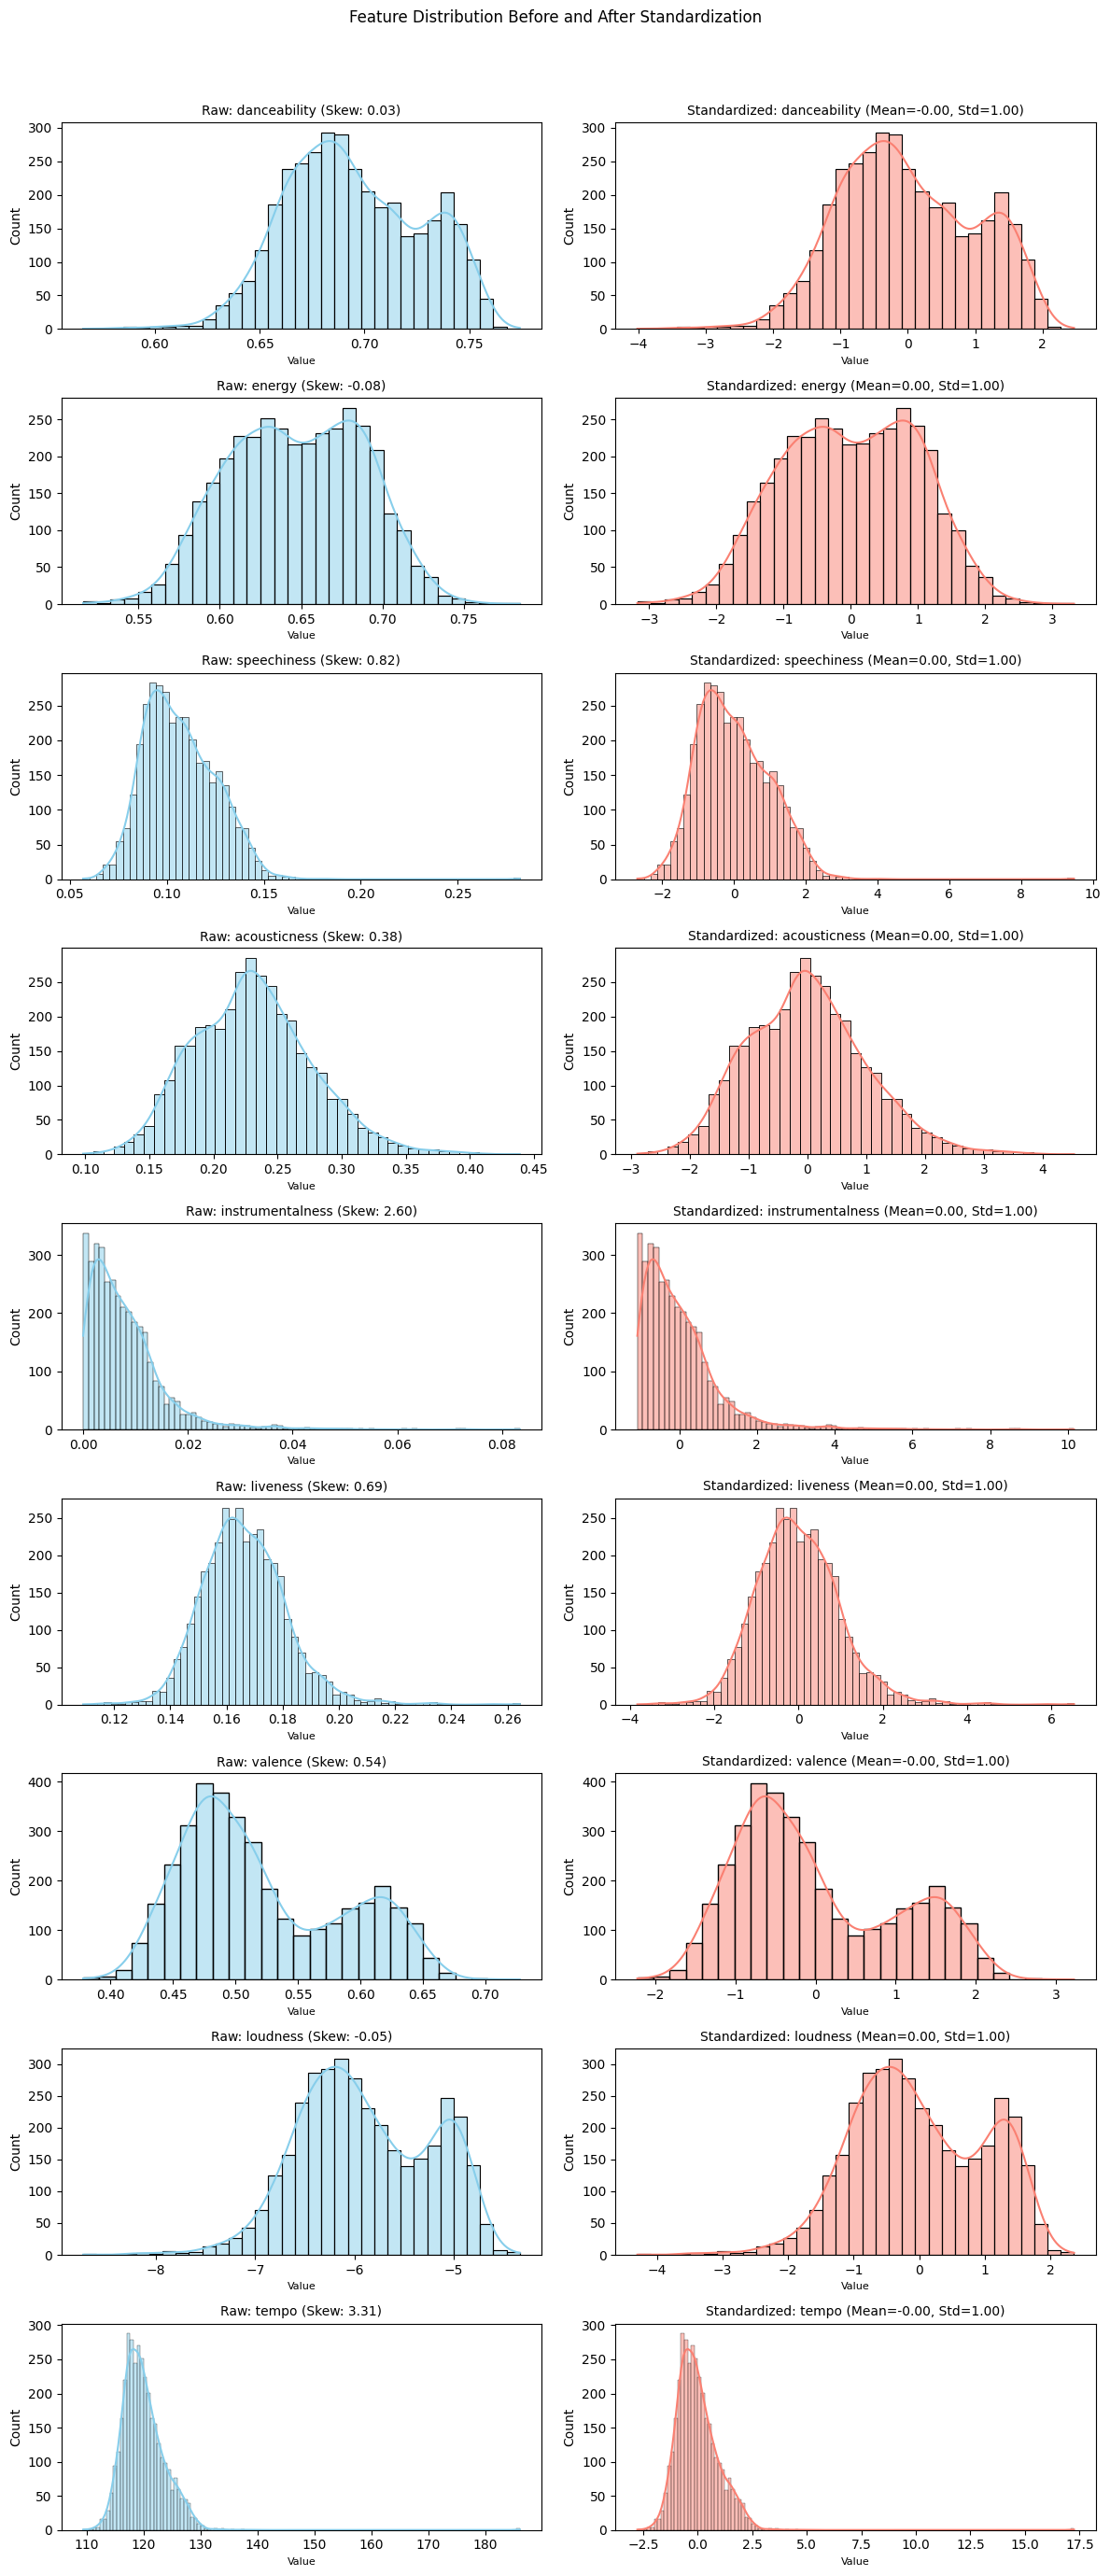

Saved feature distributions plot to 'feature_distributions_before_after_standardization.png'.
----------------------------------------


In [ ]:
# --- 1. Preprocessing and Aggregation ---
aggregated_df, sampled_charts, merged_df = preprocess_charts_data(charts_df, audio_features_df, return_intermediates=True)

# 1. Output Preprocessed and Merged DataFrame Heads
print("\n" + "="*50)
print("INTERMEDIATE DATAFRAME HEADS")
print("="*50)
print("\nFiltered Charts (sampled_charts) Head:")
display(sampled_charts.head())
print("\nMerged Data (merged_df) Head:")
display(merged_df.head())
print("\nAggregated Song Profiles (aggregated_df) Head:")
display(aggregated_df.head())
print("-" * 50)

# --- 2. Standardization ---
X_raw, X_scaled = standardize_features(aggregated_df)

# --- 2.1. Feature Distribution Plotting ---
plot_feature_distributions(X_raw, pd.DataFrame(X_scaled, columns=FEATURE_COLS))

After merging the two datasets on the "song id" key, we quickly ran into issued related to the size of our dataset. This merged dataset contained all features from both datasets. However, it did drop any rows were all features were not filled -- i.e. it dropped any rows that had null values. Even after this data filtering we still had a dataset of almost 400,000 rows and 28 features. That is roughly 10.8 million pieces of data within the dataset. Running data mining methods on this large of a dataset with our giving compute resources on Google Collab would prove to be unattainable. As a result, we devised a plan to reduce the size of our dataset while maintaining regional and temporal qualities of the data.

We did this by condensing down our dataset through aggregation methods. Our original dataset consisted of the Top 200 songs across different regions (countries) of the world for every single day between 2017 through 2021. And our goal was to be able to determine the dominant music profile in different countries over time. Therefore, we determined that we could still well acheive this goal, but still reduce the size of our dataset, by determining what features of the merged dataset truly were represetative of our music profile and find a way to combine them to encompass the overall sentiment of the Top 200 songs. As a result, we decided to retain the 9 Audio Features `[danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence, loudness, tempo]` as well as the `date` and the `region` (country). The value for each of the 9 audio features would be the average of its value across the Top 200 songs for a specific date and region. Additionally, we would only take the 1st date of every month, rather than do this for every single day. For example, The first row of the Aggregated DataFrame above represented the average value of the 9 Audio Features as a result of the Top 200 songs in Argentina on January 1st, 2017. And then so on and so forth.  

By performing these aggeregation operations on our datasets, we were then able to reduce the size our dataset by almost 100% -- from 384,785 to 3,605. There is always a tradeoff when you proceed with data reduction within a dataset. You do lose some granularity and nuance that would otherwise likely be present in the analysis. However, it must be noted that this reduction was necessary to perform any sort of viable analysis. Furthermore, we deduced that through this aggregated method we were still able to retain information about the overall music profile as a result of an assumption taht the Top 200 songs are reflective of a regions music preferences. Any outliers would be minimized through this averaging processes. Additionally, by taking only the 1st of each month, we still had enough data points to build a cohesive model that could later be used to predict the music profile of the other days of the month for different regions and time periods. Thus, these data pre-processing methods allows us to efficiently compare the musical profiles across various regions and dates throughout our date range.

**Side Note:** When it comes to the Audio Features, we would like to point out that they are all valued on what may be different scales. For example, `tempo` exists on a raw scale range of 110 - 130, while `liveliness` exists on a raw scale range of 0.12 - 0.22. However, we didn't want these differences in raw values between the feature to affect the feature importance  when building out our data mining model. Therefore we applied standardization to all our audio feature. The standardization transformation is displayed above in the plot output. The grahp on the left is the audio feature distribtuion in its raw form and the graph on the right is after standardization is applied. As you can see, the distribution pattern remains the same, but the raw values are now consistnent. These plots serve to validate that we maintained the same distribution of values when scaling from their actual values to a range with a mean of 0 with a standard deviation of 1. By ensuring all features are on a comparable scale, we mitigate the risk of features with naturally larger numerical ranges dominating the subsequent clustering algorithms. This allows for unbiased clusters to form without the noise of a larger range of values in certain features.

## **Step 2. Core Methodology**
---
This step applies various clustering and embedding techniques to identify and characterize distinct music profiles and their temporal evolution. It involves:
*   **K-Means Clustering**
*   **DBSCAN Clustering**
*   **Comparison of Clustering**: Decide which clustering algorithm provided the best clusters (strengths and weaknesses).
*   **Item2Vec Embeddings**: Utilizing Word2Vec on sequences of songs to create cultural vectors representing regional music tastes and their shifts.

In [ ]:
def find_optimal_k(X_scaled, k_range=range(2, 16)):
    """Computes and plots the Elbow Method to suggest optimal K."""
    print("--- 2.2. K-Means: Finding Optimal K (Elbow Method) ---")

    inertia = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertia, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.grid(True)
    plt.savefig('elbow_method.png')
    plt.show()
    plt.close()
    print("Saved Elbow Method plot to 'elbow_method.png'.")
    print("-" * 40)

Through trial and error we discovered that cosine distance provided the best clustering for this method. Since cosine distance measures the angle (similarity) between songs, we were able to find patterns between the audio signatures to create shape based clusters. This proved better than Euclidean distance which found absolute distance of songs by the features instead of capturing the shape of the music vectors.

In [ ]:
def run_kmeans_clustering(song_profiles, X_scaled, n_clusters):
    """Runs K-Means, profiles clusters, and calculates silhouette score."""
    print(f"--- 3. K-Means Clustering (K={n_clusters}) ---")

    # 1. Normalize for Cosine Distance
    X_normalized = normalize(X_scaled, norm='l2')

    # 2. Run K-Means
    kmeans_final = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans_final.fit(X_normalized)

    kmeans_results = song_profiles.copy()
    kmeans_results['song_type_cluster'] = kmeans_final.labels_

    # 3. Cluster Profiles
    cluster_profiles_df = (
        kmeans_results.groupby('song_type_cluster')[FEATURE_COLS].mean().round(3)
    )
    print("\nCluster Profiles (Mean Audio Features)")
    display(cluster_profiles_df)

    # 4. Silhouette Score (Cosine)
    silhouette_avg = silhouette_score(X_normalized, kmeans_final.labels_, metric='cosine')
    print(f"\n--- Silhouette Score (Cosine Metric): {silhouette_avg:.4f}")
    print("-" * 40)

    return kmeans_results, X_normalized, cluster_profiles_df, kmeans_final

In [ ]:
def run_dbscan_clustering(song_profiles, X_scaled):
    """Performs DBSCAN clustering on UMAP-reduced dimensions."""
    print("--- 5. DBSCAN Clustering (UMAP-Reduced) ---")

    # 1. Run UMAP
    umap_model = umap.UMAP(
        n_neighbors=15,
        n_components=9,
        min_dist=0.1,
        metric='cosine',
        random_state=42,
        n_jobs=1
    )
    X_umap = umap_model.fit_transform(X_scaled)
    print(f"UMAP reduction complete. Data shape: {X_umap.shape}")

    # 2. Run DBSCAN
    dbscan_clusterer = DBSCAN(
        eps=0.5,
        min_samples=5,
        metric='euclidean'
    )
    labels = dbscan_clusterer.fit_predict(X_umap)

    dbscan_results = song_profiles.copy()
    dbscan_results['song_type_cluster'] = labels

    # 3. Cluster metrics
    unique_labels = np.unique(labels)
    n_clusters = len(unique_labels[unique_labels != -1])
    print(f"Number of clusters found (excluding noise): {n_clusters}")
    print("Cluster counts:\n", pd.Series(labels).value_counts().sort_index())

    mask = labels != -1
    if mask.sum() > 1 and len(np.unique(labels[mask])) > 1:
        sil_score = silhouette_score(X_umap[mask], labels[mask])
        print(f"\nSilhouette Score (DBSCAN, excluding noise): {sil_score:.4f}")
    else:
        print("\nNot enough non-noise points for silhouette score.")

    # 4. Visualization of DBSCAN Clusters
    pca_umap = PCA(n_components=2)
    X_pca_umap = pca_umap.fit_transform(X_umap)
    plt.figure(figsize=(10, 6))

    unique_labels = np.unique(labels)

    for i, lab in enumerate(unique_labels):
        mask_lab = labels == lab
        label_text = 'Noise (-1)' if lab == -1 else f'Cluster {lab}'

        # Use SHARED_COLOR_MAP for consistent coloring of clusters 0, 1, 2, 3
        if str(lab) in SHARED_COLOR_MAP:
            color = SHARED_COLOR_MAP[str(lab)]
        else:
            # Fallback for unexpected cluster IDs, though we expect 0-3 and -1
            color = 'gray'

        plt.scatter(
            X_pca_umap[mask_lab, 0], X_pca_umap[mask_lab, 1],
            s=18, label=label_text, alpha=0.7, color=color
        )

    plt.title("DBSCAN Clusters Visualized with PCA on UMAP", fontsize=16)
    plt.xlabel(f"PCA Component 1 ({pca_umap.explained_variance_ratio_[0]*100:.1f}% Variance)")
    plt.ylabel(f"PCA Component 2 ({pca_umap.explained_variance_ratio_[1]*100:.1f}% Variance)")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('dbscan_clusters_pca_umap.png')
    plt.show()
    plt.close()
    print("Saved DBSCAN clusters plot to 'dbscan_clusters_pca_umap.png'.")
    print("-" * 40)

    return dbscan_results, X_umap, n_clusters

In [ ]:
def visualize_clusters_2d(song_profiles, X_normalized, n_clusters, title_prefix="K-Means"):
    """Visualizes the clusters using PCA and t-SNE with a consistent color map."""
    print(f"--- 4. Cluster Visualization ({title_prefix} - PCA & t-SNE) ---")

    # --- CORRECTION: Prepare Mapping and Color Palette ---

    # 1. Create a dictionary that maps the string ID ('0', '1', '2'...) to the descriptive name
    CLUSTER_ID_TO_NAME = {str(k): v for k, v in CLUSTER_NAMES.items()}

    # 2. Create a color palette using the descriptive names as keys
    # This ensures the colors match the SHARED_COLOR_MAP values
    DESCRIPTIVE_COLOR_MAP = {
        CLUSTER_ID_TO_NAME[k]: v
        for k, v in SHARED_COLOR_MAP.items()
        if k in CLUSTER_ID_TO_NAME
    }
    # -----------------------------------------------------

    # 1. PCA for Visualization
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(X_normalized)
    pca_variance = pca.explained_variance_ratio_

    print("\nExplained Variance by 2 Principal Components:")
    print(f"PC1: {pca_variance[0]:.3f} ({pca_variance[0]*100:.1f}%)")
    print(f"PC2: {pca_variance[1]:.3f} ({pca_variance[1]*100:.1f}%)")

    pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

    # 3. Map the numerical ID to the descriptive name for plotting
    pca_df['Cluster'] = song_profiles['song_type_cluster'].astype(str).map(CLUSTER_ID_TO_NAME)


    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='PC1', y='PC2', hue='Cluster', data=pca_df,
        # Use the palette based on descriptive names
        palette=DESCRIPTIVE_COLOR_MAP, alpha=0.7, legend="full"
    )
    plt.title(f'{title_prefix} Clusters Visualized with PCA (Cosine Distance)')
    plt.xlabel(f'PC1 ({pca_variance[0]*100:.1f}% Variance)')
    plt.ylabel(f'PC2 ({pca_variance[1]*100:.1f}% Variance)')
    plt.grid(True)
    plt.savefig(f'{title_prefix}_clusters_pca.png')
    plt.show()
    plt.close()
    print(f"Saved PCA plot to '{title_prefix}_clusters_pca.png'.")

    # 2. t-SNE Visualization
    print("\n--- Running t-SNE ---")
    tsne = TSNE(
        n_components=2, perplexity=30, random_state=42,
        n_jobs=-1, verbose=0, metric='cosine', init='pca'
    )
    start_time = time.time()
    tsne_components = tsne.fit_transform(X_normalized)
    end_time = time.time()
    print(f"t-SNE completed in {end_time - start_time:.2f} seconds.")

    tsne_df = pd.DataFrame(tsne_components, columns=['TSNE-1', 'TSNE-2'])

    # Map the numerical ID to the descriptive name for plotting
    tsne_df['Cluster'] = song_profiles['song_type_cluster'].astype(str).map(CLUSTER_ID_TO_NAME)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='TSNE-1', y='TSNE-2', hue='Cluster', data=tsne_df,
        # Use the palette based on descriptive names
        palette=DESCRIPTIVE_COLOR_MAP,
        legend='full', alpha=0.7, s=50
    )
    plt.title(f'{title_prefix} Clusters (Cosine) Visualized with t-SNE')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.grid(True)
    plt.savefig(f'{title_prefix}_clusters_tsne.png')
    plt.show()
    plt.close()
    print(f"Saved t-SNE plot to '{title_prefix}_clusters_tsne.png'.")
    print("-" * 40)

In [ ]:
def plot_cluster_feature_ranges(df_profiles, method_name, feature_cols):
    """Plots the distribution (boxplot) of each raw audio feature grouped by cluster, using subplots."""
    print(f"--- Feature Range Plotting ({method_name}) ---")

    # Filter out Noise (-1) clusters for DBSCAN profiling
    if method_name == 'DBSCAN':
        df_profiles = df_profiles[df_profiles['song_type_cluster'] != -1].copy()

    df_melt = df_profiles.melt(
        id_vars=['song_type_cluster'],
        value_vars=feature_cols,
        var_name='Audio Feature',
        value_name='Value'
    )

    # Convert cluster label to string for categorical plotting
    df_melt['Cluster'] = df_melt['song_type_cluster'].astype(str)

    # Determine the number of unique clusters for coloring
    unique_clusters = sorted(df_melt['Cluster'].unique())
    n_clusters = len(unique_clusters)

    # Calculate optimal grid layout (3 columns)
    n_features = len(feature_cols)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() # Flatten the array for easy iteration

    # Map cluster IDs to colors for matplotlib
    color_map = {k: SHARED_COLOR_MAP[k] for k in df_melt['Cluster'].unique() if k in SHARED_COLOR_MAP}


    for i, feature in enumerate(feature_cols):
        # Filter the melted data for the current feature
        feature_data = df_melt[df_melt['Audio Feature'] == feature]

        # Plot boxplot for the current feature on the current axis
        sns.boxplot(
            data=feature_data,
            x='Cluster',
            y='Value',
            order=unique_clusters, # Ensure order is sorted
            palette=color_map, # Use SHARED_COLOR_MAP
            ax=axes[i]
        )

        axes[i].set_title(f'Feature: {feature.title().replace("_", " ")}', fontsize=12)
        axes[i].set_xlabel('Cluster ID', fontsize=10)
        axes[i].set_ylabel('Raw Value', fontsize=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.5)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f'Distribution of Raw Audio Features by Cluster ({method_name})', y=1.02, fontsize=18)
    plt.tight_layout()
    plt.savefig(f'feature_ranges_{method_name.lower()}.png')
    plt.show()
    plt.close()
    print(f"Saved cluster feature ranges plot to 'feature_ranges_{method_name.lower()}.png'.")
    print("-" * 40)

In [ ]:
def create_super_region_map(region_mapping_dict: dict) -> pd.DataFrame:
    """Creates a DataFrame mapping regions to their super regions."""
    map_list = []
    for super_region, countries in region_mapping_dict.items():
        for country in countries:
            map_list.append({'region': country, 'super_region': super_region})
    return pd.DataFrame(map_list)

In [ ]:
def prepare_temporal_data(
    data_df: pd.DataFrame,
    feature_cols: list,
    model,
    region_mapping: dict
):
    """
    Performs clustering, calculates cluster shares for regions, and aggregates
    results by super region.
    """

    # 1. Initial Clustering
    temporal_data = data_df[['track_name', 'artist_names', 'date', 'region', 'rank'] + feature_cols].copy()
    k_means_data_raw = temporal_data[feature_cols].copy()

    # Assuming the scaler has been fitted previously, or we fit and transform here
    # For a real-world scenario, you'd use a saved scaler.
    scaler = StandardScaler()
    k_means_data_scaled = scaler.fit_transform(k_means_data_raw)
    temporal_data['final_cluster_assignment'] = model.predict(k_means_data_scaled)

    print(f"Prediction successful! Full data shape: {temporal_data.shape}")
    display(temporal_data.head())

    # 2. Calculate Cluster Shares by Date and Region (Country Level)
    final_temporal_report = calculate_cluster_shares(
        temporal_data,
        ['date', 'region', 'final_cluster_assignment'],
        'rank' # Counting the number of profiles (songs)
    )

    # 3. Super Region Aggregation
    super_region_map_df = create_super_region_map(region_mapping)

    super_region_report_merged = pd.merge(
        final_temporal_report,
        super_region_map_df,
        on='region',
        how='left'
    )

    # 4. Calculate Cluster Shares by Date and Super Region
    super_region_trends = calculate_cluster_shares(
        super_region_report_merged,
        ['date', 'super_region', 'final_cluster_assignment'],
        'profile_count' # Summing the country counts to get the super region count
    )

    print("\nSuper Region Trends Data Ready:")
    display(super_region_trends.head())

    return final_temporal_report, super_region_trends

In [ ]:
def calculate_cluster_shares(df: pd.DataFrame, group_cols: list, count_col: str) -> pd.DataFrame:
    """Calculates the percentage share of each cluster within defined groups."""
    report = (
        df.groupby(group_cols)[count_col]
        .sum()
        .reset_index(name='profile_count')
    )

    # Calculate the total count per group (e.g., per day/region)
    total_profiles_per_group = report.groupby(group_cols[:-1])['profile_count'].transform('sum')

    # Calculate percentage
    report['percentage_of_chart'] = (report['profile_count'] / total_profiles_per_group) * 100
    return report

In [ ]:
# --- Global Configuration Constants ---
VECTOR_SIZE = 100  # Dimension of the embedding vector
WINDOW = 10        # Max distance for context (co-occurrence)
MIN_COUNT = 5      # Ignore tracks appearing fewer than 5 times
WORKERS = 4        # Number of CPU cores
EPOCHS = 10        # Number of training epochs
MIN_SEQUENCE_LENGTH = 10 # Filter out charts with fewer than this many tracks
RANDOM_SEED = 42   # For reproducibility

def setup_item2vec_df(merged_df: pd.DataFrame) -> pd.DataFrame:
    """Prepares the input DataFrame by dropping unnecessary columns."""

    # Run pip install gensim outside this function or use environment management
    # !pip install gensim

    # item2vec_df already dropped these in original, but good practice to keep the preparation step
    item2vec_df = merged_df.drop(
        columns=['track_name', 'artist_names'],
        errors='ignore'
    ).copy()
    print("Input DataFrame prepared.")
    return item2vec_df

In [ ]:
def generate_item2vec_sequences(df: pd.DataFrame) -> list[list[str]]:
    """
    Groups chart data by date/region, extracts the ordered sequence of track IDs,
    and filters sequences by minimum length.
    """
    print("--- 1. Generating Chart Sequences ---")

    # Sort data correctly to ensure rank order for sequence extraction
    df_sorted = df.sort_values(by=['date', 'region', 'rank'])

    # Group by the unique chart identifier (date + region) and extract the sequence of track IDs
    sequences = (
        df_sorted.groupby(['date', 'region'])['url_id']
        .apply(list)
        .tolist()
    )

    # Filter for sequences with meaningful length
    filtered_sequences = [s for s in sequences if len(s) > MIN_SEQUENCE_LENGTH]

    print(f"Generated {len(sequences)} total chart sequences.")
    print(f"Kept {len(filtered_sequences)} sequences (length > {MIN_SEQUENCE_LENGTH}).")

    return filtered_sequences

In [ ]:
def train_item2vec_model(sequences: list[list[str]]) -> Word2Vec:
    """Trains the Word2Vec model using the generated chart sequences."""
    print("\n--- 2. Training Word2Vec (Item2Vec) Model ---")

    item2vec_model = Word2Vec(
        vector_size=VECTOR_SIZE,
        window=WINDOW,
        min_count=MIN_COUNT,
        sg=1,       # Skip-Gram
        workers=WORKERS,
        seed=RANDOM_SEED
    )

    # Build vocabulary
    item2vec_model.build_vocab(sequences)
    vocab_size = len(item2vec_model.wv)
    print(f"Vocabulary built. Unique track IDs (min_count > {MIN_COUNT}): {vocab_size}")

    # Train the model
    item2vec_model.train(
        sequences,
        total_examples=item2vec_model.corpus_count,
        epochs=EPOCHS,
        compute_loss=True
    )
    print("Model training complete.")

    return item2vec_model

In [ ]:
def extract_and_aggregate_features(
    df: pd.DataFrame,
    model: Word2Vec,
    region_map: dict
) -> pd.DataFrame:
    """
    Generates embedding features, aggregates them temporally, and maps to super-regions.

    This function has been updated to use pd.concat to fix the PerformanceWarning.
    """
    print("\n--- 3. Generating & Aggregating Temporal Features ---")

    # 1. Create a dictionary for quick embedding lookup
    embedding_dict = {
        word: model.wv[word]
        for word in model.wv.index_to_key
    }
    embedding_columns = [f'embedding_{i}' for i in range(VECTOR_SIZE)]

    def get_embedding(url_id: str) -> list[float]:
        """Safely retrieves embedding vector, returns NaNs if track wasn't trained."""
        return embedding_dict.get(url_id, [np.nan] * VECTOR_SIZE)

    # ====================================================================
    # 2. FIX: Apply embeddings and join using pd.concat
    # ====================================================================

    # Calculate the embedding vectors and put them into a temporary DataFrame
    embedding_series = df['url_id'].apply(lambda x: pd.Series(get_embedding(x)))
    embedding_series.columns = embedding_columns

    # Use pd.concat to efficiently join the new embedding columns in one operation.
    # We use df.reset_index(drop=True) to ensure the indices align perfectly.
    df_with_embeddings = pd.concat(
        [df.reset_index(drop=True), embedding_series.reset_index(drop=True)],
        axis=1
    )

    # Clean up rows where the track ID was too rare (min_count filter)
    df_with_embeddings.dropna(subset=embedding_columns, inplace=True)
    print(f"Dropped {len(df) - len(df_with_embeddings)} rows (track not in vocabulary).")

    # 3. Final Temporal Aggregation (Creating the 'Cultural Vector')
    # Average the 100 dimensions for all tracks in a chart (date/region)
    cultural_shift_df = (
        df_with_embeddings.groupby(['date', 'region'])[embedding_columns]
        .mean()
        .reset_index()
    )
    print("Temporal aggregation (mean embedding per date/region) complete.")

    # 4. Add Super Region mapping (Logic remains clean)
    map_list = [
        {'region': country, 'super_region': super_region}
        for super_region, countries in region_map.items()
        for country in countries
    ]
    super_region_map_df = pd.DataFrame(map_list)

    # Merge cultural_shift_df with Super Region map
    cultural_shift_df = pd.merge(
        cultural_shift_df,
        super_region_map_df,
        on='region',
        how='left'
    )
    print("Super Region mapping added.")

    return cultural_shift_df


K-MEANS CORE METHODOLOGY
--- 2.2. K-Means: Finding Optimal K (Elbow Method) ---


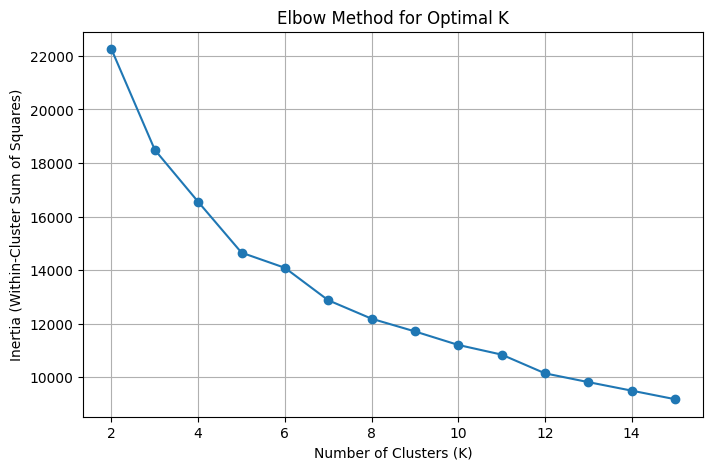

Saved Elbow Method plot to 'elbow_method.png'.
----------------------------------------
--- 3. K-Means Clustering (K=4) ---

Cluster Profiles (Mean Audio Features)


danceability  energy  speechiness  acousticness  \
song_type_cluster                                                    
0                         0.731   0.692        0.113         0.222   
1                         0.665   0.608        0.094         0.278   
2                         0.680   0.659        0.099         0.187   
3                         0.697   0.621        0.120         0.235   

                   instrumentalness  liveness  valence  loudness    tempo  
song_type_cluster                                                          
0                             0.004     0.163    0.606    -5.094  122.380  
1                             0.008     0.171    0.490    -6.448  118.272  
2                             0.007     0.155    0.487    -5.796  118.150  
3                             0.014     0.177    0.479    -6.409  120.655


--- Silhouette Score (Cosine Metric): 0.4178
----------------------------------------

--------------------------------------------------
K-MEANS CLUSTERING RESULT HEADS
--------------------------------------------------

Song Profiles DataFrame (kmeans_profiles) Head:


date     region  danceability    energy  speechiness  acousticness  \
0 2017-01-01  Argentina      0.710476  0.750222     0.108338      0.158411   
1 2017-01-01  Australia      0.659789  0.666553     0.108253      0.174004   
2 2017-01-01    Austria      0.659977  0.695349     0.101277      0.160947   
3 2017-01-01    Belgium      0.648007  0.664216     0.100773      0.200027   
4 2017-01-01    Bolivia      0.715404  0.745766     0.102760      0.158000   

   instrumentalness  liveness   valence  loudness       tempo  \
0          0.002157  0.173619  0.615313 -4.995603  119.854492   
1          0.009501  0.156926  0.491522 -5.983618  119.512414   
2          0.010582  0.171065  0.505166 -5.629752  118.980481   
3          0.009026  0.163286  0.506282 -6.024583  118.792000   
4          0.002784  0.159349  0.607547 -4.936085  116.691298   

   song_type_cluster  
0                  0  
1                  2  
2                  2  
3                  2  
4                  0


Cluster Profiles (cluster_profiles) Head:


danceability  energy  speechiness  acousticness  \
song_type_cluster                                                    
0                         0.731   0.692        0.113         0.222   
1                         0.665   0.608        0.094         0.278   
2                         0.680   0.659        0.099         0.187   
3                         0.697   0.621        0.120         0.235   

                   instrumentalness  liveness  valence  loudness    tempo  
song_type_cluster                                                          
0                             0.004     0.163    0.606    -5.094  122.380  
1                             0.008     0.171    0.490    -6.448  118.272  
2                             0.007     0.155    0.487    -5.796  118.150  
3                             0.014     0.177    0.479    -6.409  120.655

--------------------------------------------------
--- Feature Range Plotting (K-Means) ---


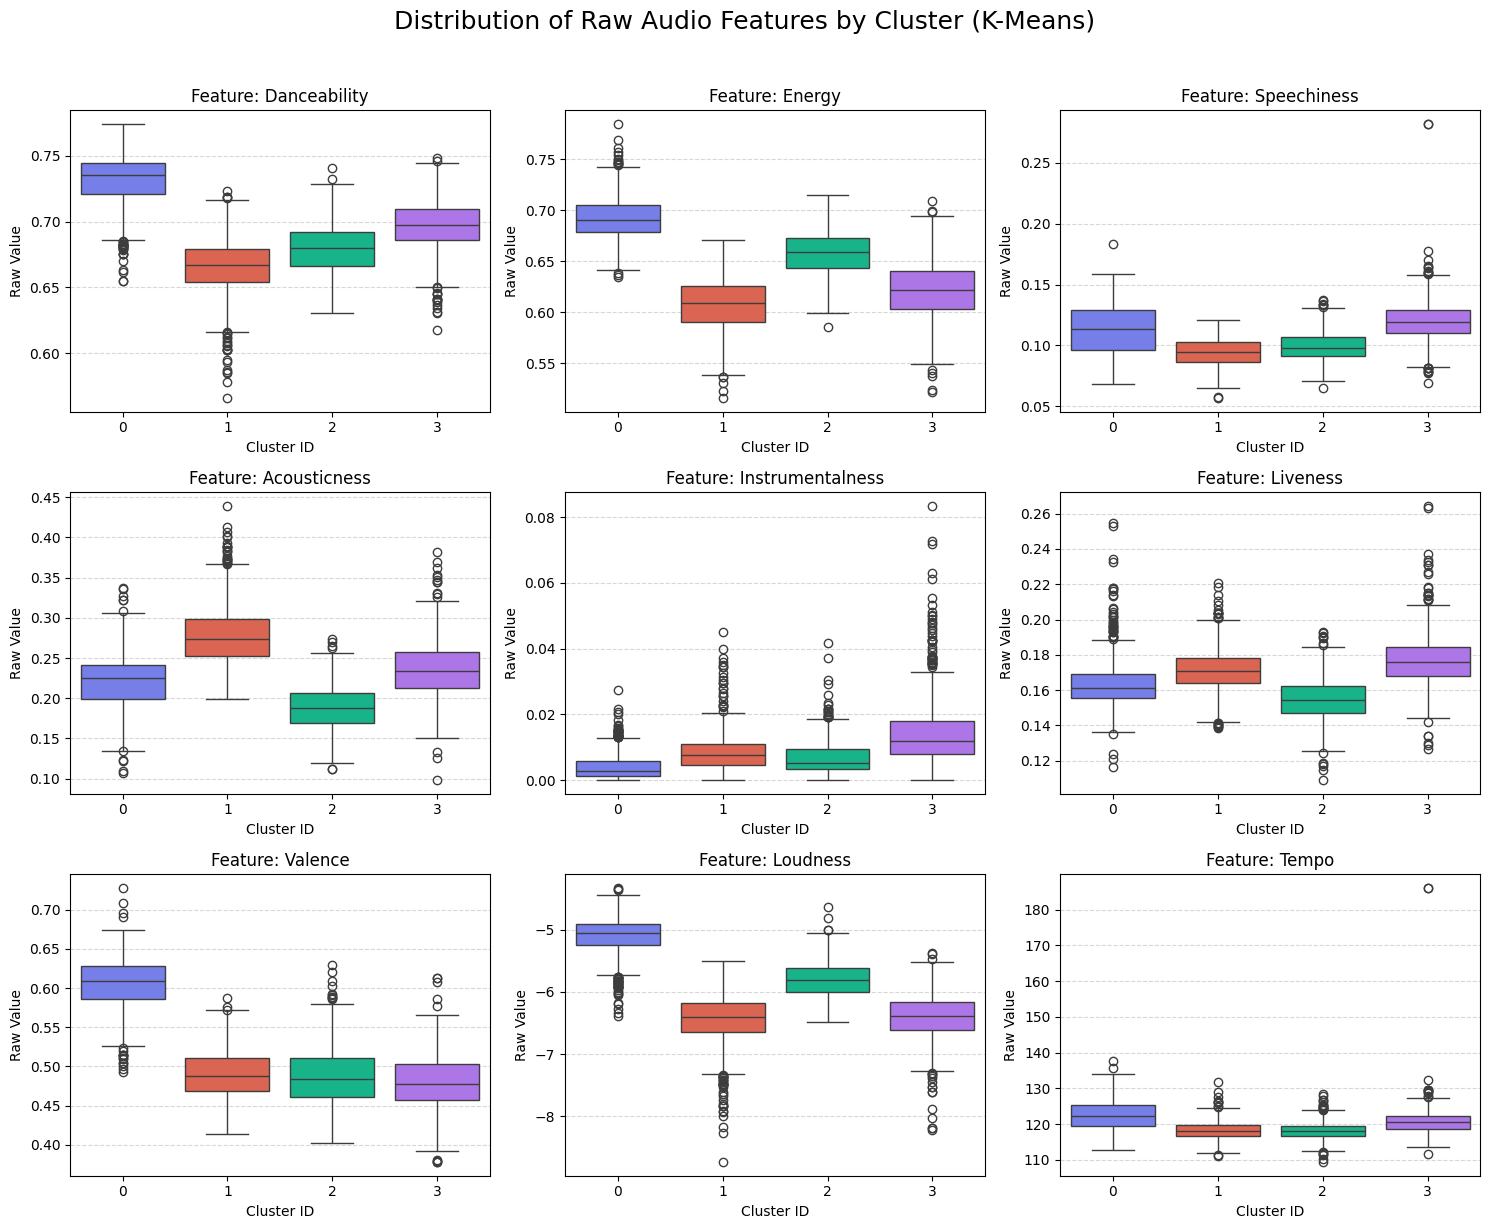

Saved cluster feature ranges plot to 'feature_ranges_k-means.png'.
----------------------------------------
--- 4. Cluster Visualization (K-Means - PCA & t-SNE) ---

Explained Variance by 2 Principal Components:
PC1: 0.387 (38.7%)
PC2: 0.205 (20.5%)


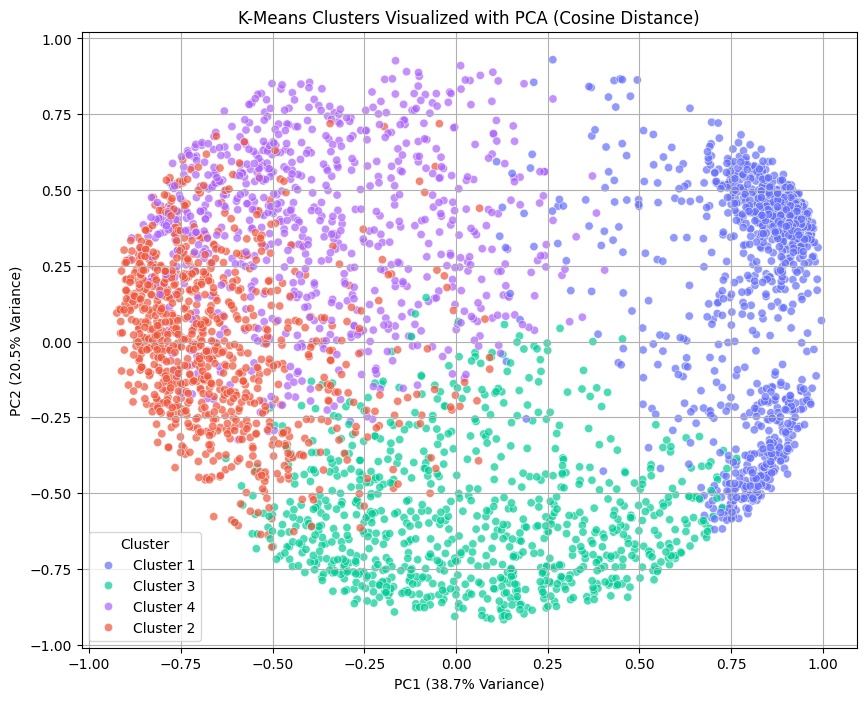

Saved PCA plot to 'K-Means_clusters_pca.png'.

--- Running t-SNE ---
t-SNE completed in 38.56 seconds.


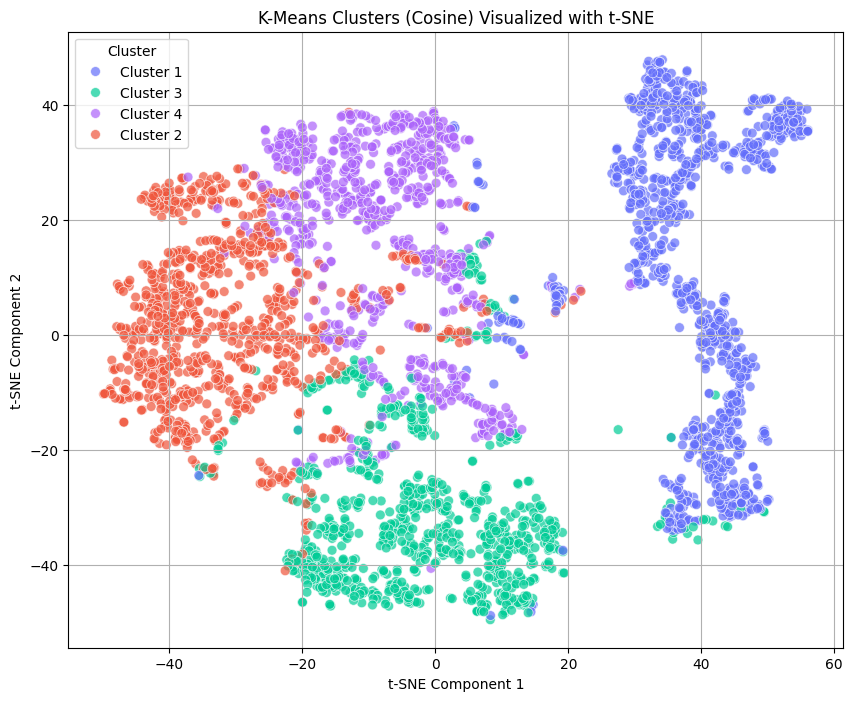

Saved t-SNE plot to 'K-Means_clusters_tsne.png'.
----------------------------------------


In [ ]:
# =================================================================
# K-MEANS PIPELINE
# =================================================================

print("\n" + "="*50)
print("K-MEANS CORE METHODOLOGY")
print("="*50)

# --- 1. K-Means: Finding Optimal K (Elbow Method) ---
find_optimal_k(X_scaled)

optimal_k = 4
kmeans_profiles, X_normalized, cluster_profiles, kmeans_model = run_kmeans_clustering(
  aggregated_df, X_scaled, optimal_k
)

# 2. Output Final Clustered DataFrame Head and Cluster Profiles
print("\n" + "-"*50)
print("K-MEANS CLUSTERING RESULT HEADS")
print("-"*50)
print("\nSong Profiles DataFrame (kmeans_profiles) Head:")
display(kmeans_profiles.head())
print("\nCluster Profiles (cluster_profiles) Head:")
display(cluster_profiles)
print("-" * 50)

# 3. K-Means Feature Ranges
plot_cluster_feature_ranges(
  pd.merge(
    kmeans_profiles[['date', 'region', 'song_type_cluster']],
    X_raw.reset_index(drop=True), # Merge cluster label back onto raw data
    left_index=True,
    right_index=True
  ),
  "K-Means", FEATURE_COLS
)

# 4. K-Means Visualization (PCA & t-SNE)
visualize_clusters_2d(kmeans_profiles, X_normalized, optimal_k, title_prefix="K-Means")


1.  **Optimal Number of Clusters (K)**:
    *   We used the elbow method and evaluated the plot below to determine the best number of k which is k = 4.

2.  **Clustering Quality (Silhouette Score)**:
    *   The K-Means clustering achieved a Silhouette Score of 0.4178 using the cosine metric. A score of ~0.4 indicates that the clusters are reasonably well-separated, and objects are assigned to appropriate clusters, though there might still be some overlap. This is representative to music since a song can fit multiple genres, and various genres can encompass different archetypes of songs.
    * We chose to use the silhoutte score to determine which clustering method performed better because we did not have any "ground truth" labels within this dataset. It was a completely unlabled, and thus, unsupervised dataset. As a result, calculating metrics such as Precision, Accuracy, Recall, and F-1 score were not realistic.

3.  **Cluster Profiles (Mean Audio Features)**:
    *   The Cluster Profile plots provided a clear characterization of each of the four identified music profiles. By observing the distributions of audio features for each cluster, we can see that no two cluster signatures are the same across the features. This shows that the clusters are likely finding distinct clusters.
    * We were able to discern a lot of interesting findings from our 4 cluster types:

      * *Cluster 1 (ID 0):* High Danceability, High Energy, High Valence (Happiness), High Loudness, High Tempo, Low Instrumentalness, Low/Medium Acousticness, Low/Medium Liveness

      * *Cluster 2 (ID 1):* Low Danceability, Low Energy, Low Speechiness, High Acousticness, Medium Instrumentalness, Medium/High Liveness, Medium Valence, Low Loudness, Medium Tempo

      * *Cluster 3 (ID 2):* Low/Medium Danceability, Medium/High Energy, Medium/High Speechiness, Low Acousticness, Low/Medium Instrumentalness, Low Liveness, Medium Valence, High/Medium Loudness, Low Tempo

      * *Cluster 4 (ID 3):* Medium/High Danceability, Low/Medium Energy, High Speechiness, Medium/High Acousticness, High Instrumentalness, High Liveness, Low Valence, Low Loudness, Medium Tempo


4.  **Visualizations (PCA & t-SNE)**:
    *   The two cluster visualizations show distinct clusters form with slight overlap matching what is indicated by the silhouette score. In both visualization methods, the red and purple clusters tend to see the most overlap, and the green cluster overlaps slightly with these. This indicates that these song profiles are similar, yet distinct when compared to the blue cluster. In both visualizations this blue cluster is distinct and shows little overlap with the others, which will be a key detail later on in the analysis.


DBSCAN CORE METHODOLOGY
--- 5. DBSCAN Clustering (UMAP-Reduced) ---
UMAP reduction complete. Data shape: (3605, 9)
Number of clusters found (excluding noise): 4
Cluster counts:
 -1       6
 0     447
 1    2563
 2      32
 3     557
Name: count, dtype: int64

Silhouette Score (DBSCAN, excluding noise): 0.3164


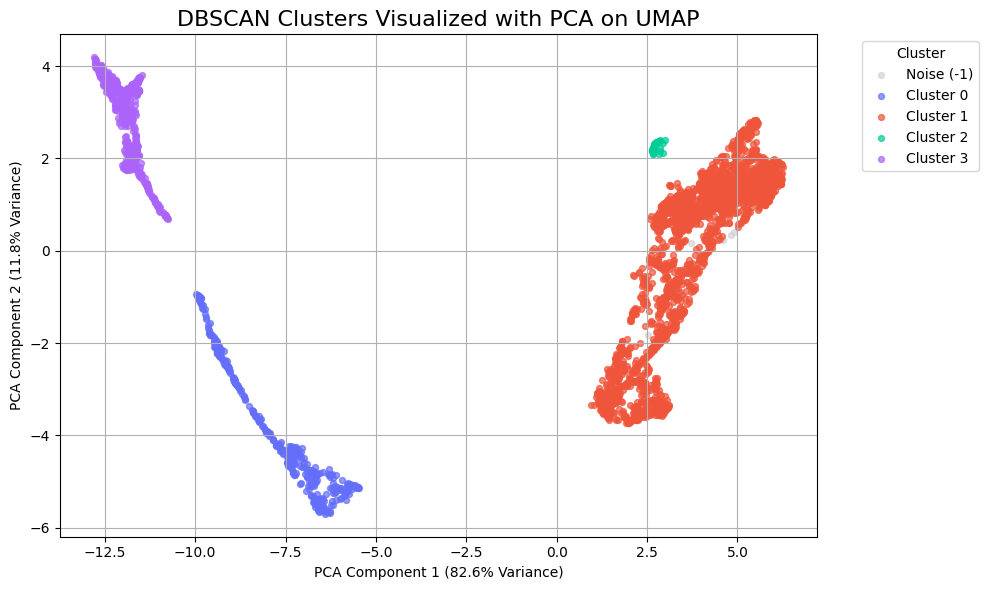

Saved DBSCAN clusters plot to 'dbscan_clusters_pca_umap.png'.
----------------------------------------

--------------------------------------------------
DBSCAN CLUSTERING RESULT HEADS
--------------------------------------------------

Song Profiles DataFrame (dbscan_profiles) Head:


date     region  danceability    energy  speechiness  acousticness  \
0 2017-01-01  Argentina      0.710476  0.750222     0.108338      0.158411   
1 2017-01-01  Australia      0.659789  0.666553     0.108253      0.174004   
2 2017-01-01    Austria      0.659977  0.695349     0.101277      0.160947   
3 2017-01-01    Belgium      0.648007  0.664216     0.100773      0.200027   
4 2017-01-01    Bolivia      0.715404  0.745766     0.102760      0.158000   

   instrumentalness  liveness   valence  loudness       tempo  \
0          0.002157  0.173619  0.615313 -4.995603  119.854492   
1          0.009501  0.156926  0.491522 -5.983618  119.512414   
2          0.010582  0.171065  0.505166 -5.629752  118.980481   
3          0.009026  0.163286  0.506282 -6.024583  118.792000   
4          0.002784  0.159349  0.607547 -4.936085  116.691298   

   song_type_cluster  
0                  0  
1                  1  
2                  1  
3                  1  
4                  0

--------------------------------------------------
--- Feature Range Plotting (DBSCAN) ---


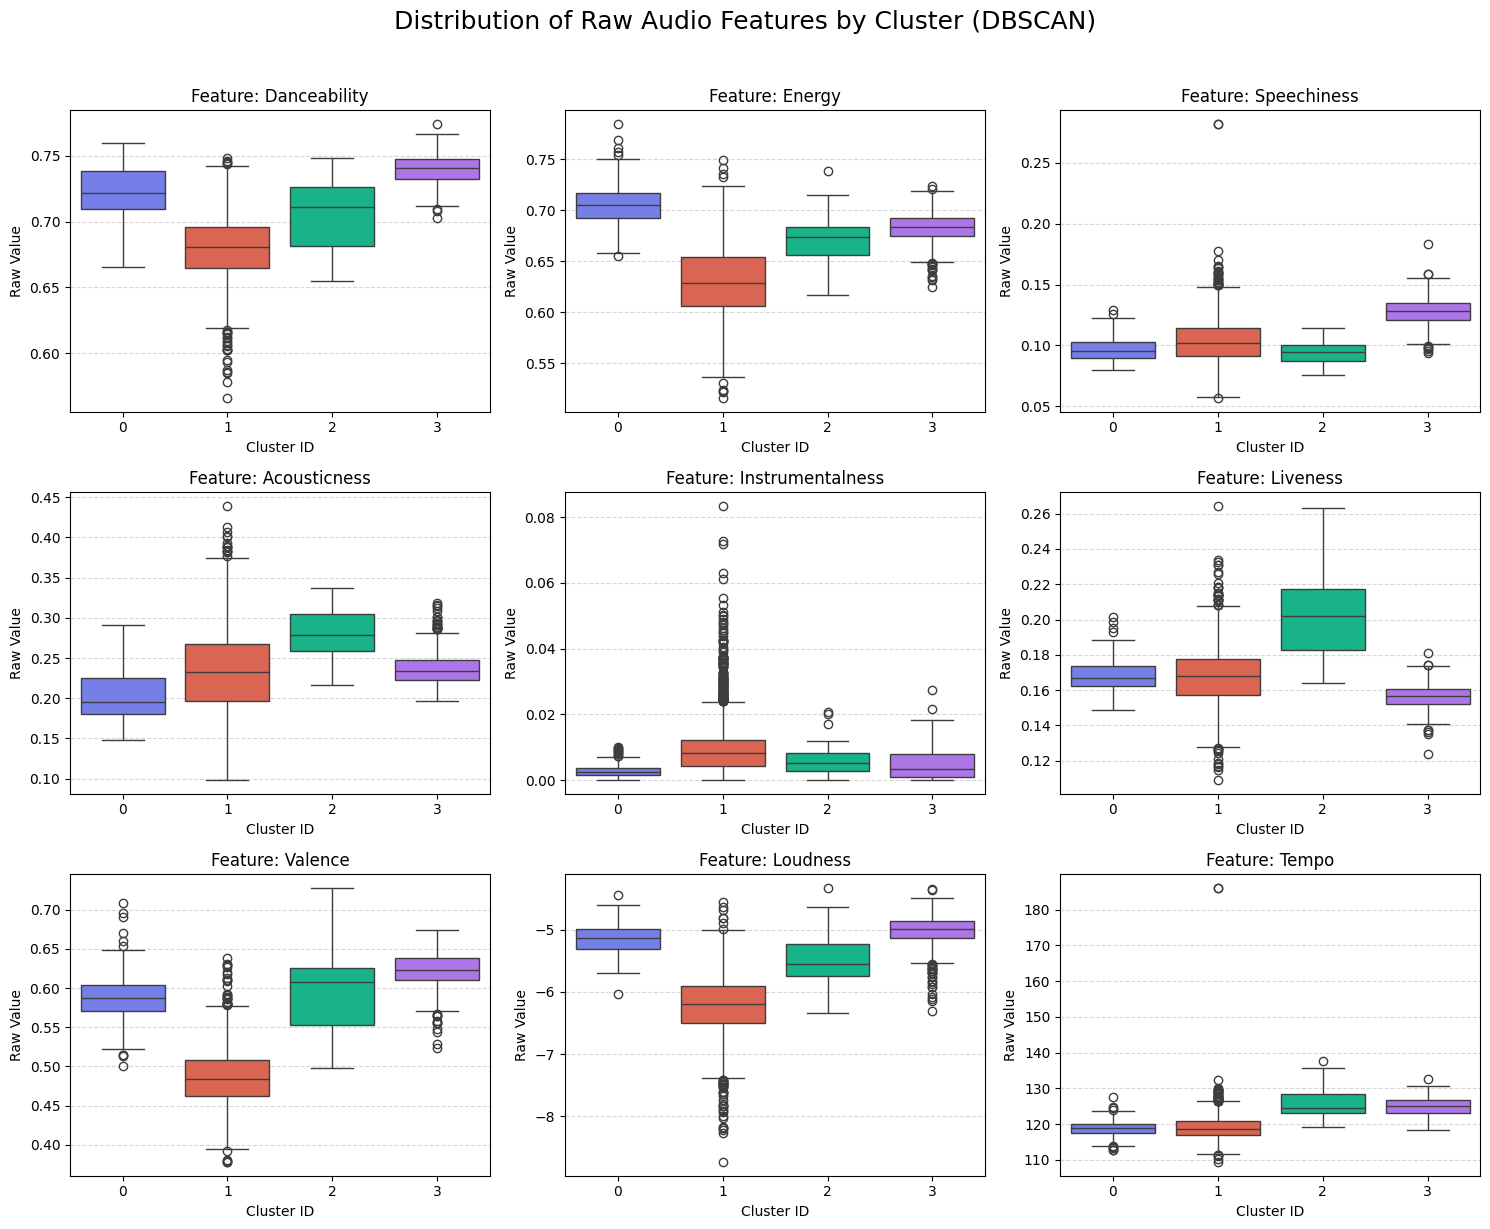

Saved cluster feature ranges plot to 'feature_ranges_dbscan.png'.
----------------------------------------


In [ ]:
# =================================================================
# DBSCAN PIPELINE
# =================================================================
print("\n" + "="*50)
print("DBSCAN CORE METHODOLOGY")
print("="*50)

dbscan_profiles, X_umap, n_dbscan_clusters = run_dbscan_clustering(
  aggregated_df, X_scaled
)

# 1. Output DBSCAN Clustered DataFrame Head
print("\n" + "-"*50)
print("DBSCAN CLUSTERING RESULT HEADS")
print("-"*50)
print("\nSong Profiles DataFrame (dbscan_profiles) Head:")
display(dbscan_profiles.head())
print("-" * 50)

# 2. DBSCAN Feature Ranges
plot_cluster_feature_ranges(
  pd.merge(
    dbscan_profiles[['date', 'region', 'song_type_cluster']],
    X_raw.reset_index(drop=True), # Merge cluster label back onto raw data
    left_index=True,
    right_index=True
  ),
  "DBSCAN", FEATURE_COLS
)


1.  **Clustering Quality (Silhouette Score)**:
    *   The DBScan clustering achieved a Silhouette Score of 0.3164. This was lower than the score we recieved in K-means, and was the part of the deciding factors of selecting the k-means clusters to be better later in the project.

2.  **Cluster Profiles (Mean Audio Features)**:
    *   The Cluster Profile plots provided a clear characterization of each of the four identified music profiles. Despite the lower sillhouette score, the feature characteristic plots showed a wider variety than the clusters generated from K-means. This does show that these clusters are distinct enough to perform the regional and temporal analysis on.

    * Once again, we were able to find quite interesting findings. Characterization for our DBSCAN clusters was similar to that of K-Means, but not quite the same:

      * *Cluster 1 (ID 0):* Medium/High Danceability, High Energy, Low/Medium Speechiness, Low Acoustiness, Low Instrumentalness, Low/Medium Liveness, Medium/High Valence, Medium/High Loudness, Low Tempo

      * *Cluster 2 (ID 1):* Low Danceability, Low Energy, Low/Medium Speechiness, Medium/High Acousticness, High Instrumentalness, Low/Medium Liveness, Low Valance, Low Loudness, Low Tempo

      * *Cluster 3 (ID 2):* Low/Medium Danceability, Low/Medium Danceability, Low Speechiness, High Acousticness, Medium/High Instrumentalness, High Liveness, Medium/High Valence, Low/Medium Loudness, High Tempo

      * *Cluster 4 (ID 3):* High Danceability, Medium/High Energy, High Speechiness, Low/Medium Acousticness, Low/Medium Instrumentalness, Low Liveness, High Valence, High Loudness, Medium/High Tempo

3.  **Visualization (PCA)**:
    *   This visalization highlighted an issue we had with DBScan in that the orange cluster was very dominant. A lot of the entries ended up in this cluster showing that the majority of our data was getting placed into a generalized category. Despite this, the 4 clusters were very distinct, and future work could look to improve upon breaking up these clusters further to find more fine grained results. This sentiment would be reflected in the analysis of the DBScan clusters in part 3.

In [ ]:
# =================================================================
# ITEM2VEC PIPELINE
# =================================================================

print("\n" + "="*50)
print("ITEM2VEC CORE METHODOLOGY")
print("="*50)

# 0. Prepare Data
item2vec_df = setup_item2vec_df(merged_df)

# 1. Generate Sequences
chart_sequences = generate_item2vec_sequences(item2vec_df)

# 2. Train Model
item2vec_model = train_item2vec_model(chart_sequences)

# 3. Extract and Aggregate Features
cultural_shift_df = extract_and_aggregate_features(
  item2vec_df,
  item2vec_model,
  REGION_MAPPING_DICT
)

EMBEDDING_PREFIX = 'embedding_'
EMBEDDING_COLS = [
    col for col in cultural_shift_df.columns
    if col.startswith(EMBEDDING_PREFIX)
]

print("\n Item2Vec Integration Complete.")
print(f"Final output DataFrame shape: {cultural_shift_df.shape}")
print("The 'cultural_shift_df' contains the average 100-dimensional cultural vector for every day/region and is mapped to Super Regions.")
print(f"Successfully extracted {len(EMBEDDING_COLS)} embedding columns.")


ITEM2VEC CORE METHODOLOGY
Input DataFrame prepared.
--- 1. Generating Chart Sequences ---
Generated 3605 total chart sequences.
Kept 3602 sequences (length > 10).

--- 2. Training Word2Vec (Item2Vec) Model ---
Vocabulary built. Unique track IDs (min_count > 5): 3760
Model training complete.

--- 3. Generating & Aggregating Temporal Features ---
Dropped 1368 rows (track not in vocabulary).
Temporal aggregation (mean embedding per date/region) complete.
Super Region mapping added.

 Item2Vec Integration Complete.
Final output DataFrame shape: (3605, 103)
The 'cultural_shift_df' contains the average 100-dimensional cultural vector for every day/region and is mapped to Super Regions.
Successfully extracted 100 embedding columns.


While the clustering methodolody did do a good job of profiling music tastes for a particular region, and we could apply the model to predict the gaps for the dates that were not part of the aggregated dataset, it is still missing a true temporal understanding of shifts in music taste around different parts of the world. We still don't have the information necessary to determine if these shifts happen at the same time or at the same rate? Are there shifts only within certain areas?

There is more than just the pure audio features of a song that contribute to this and is something that is currently going unanswered with just the clustering methodology. As a result, we decided to implement Song2Vec, an Item2Vec pipeline that creates cultural vectors which aim to represent the evolving musical tastes of regions over time by leveraging the sequence of song presence in the Top 200 charts across different regions. They will serve as the basis for temporal analysis later on.

1.  **Data Preparation and Sequence Generation**:
    *   The merged dataframe of 384,785 rows was transformed into 3,605 total chart sequences. All features of this merged dataset (minus duplicates such a song title and artist) were kept. Each sequence represents the ordered list of  track IDs for a specific date and region. Out of these, 3,602 sequences were kept after filtering for a minimum length of 10 tracks, ensuring that only meaningful songs contribute to learning.

2.  **Item2Vec Model Training**:
    *   A Word2Vec (Item2Vec) model was successfully trained on these sequences. The model built a vocabulary of 3,760 unique track IDs that appeared more than 5 times. This vocabulary represents the set of songs for which the model learned contextual embeddings. This produced 100-dimensional embedding vectors for each track in the vocabulary.

3.  **Feature Extraction and Aggregation**:
    *   After generating embeddings, 1,368 rows were dropped because their tracks were not in the model's vocabulary. This indicates that a portion of the entries contained tracks that were too rare to learn meaningful embeddings for.
    *   The 100-dimensional embeddings of the remaining tracks were then aggregated by date and region by calculating the mean of the embeddings. Lastly we mapped the regions to their respective super regions allowing for analysis at a broader geographical level.



## **Step 3. Interpretation & Analysis**
---
This step focuses on making sense of the clustered song profiles and learned embeddings. It involves:
*   **Regional Distribution Analysis**: Understanding how music profiles (clusters) are distributed across different countries and super-regions. Using plots which show how the percentage a certain cluster holds of the chart within a region/super region.
*   **Choropleth Mapping**: Visualizing the dominant music profiles globally.
*   **Temporal Trend Analysis**: Examining how song type popularity evolve over time in various regions. Using plots which show the percentage of the chart occupied over time in the regions and super regions.
*   **Examine Rates of Cultural Shift**: Quantifying the rate of change in regional music tastes based on embedding distances. Calculates shift index by plotting the rate of change between consecutive monthly embeddings in each region.

In [ ]:
def analyze_regional_distribution(song_profiles, method_name, cluster_names=None):
    """Calculates and visualizes cluster distribution by region and super region."""
    print(f"--- 6. Regional Distribution Analysis ({method_name}) ---")

    # 1. Prepare data (Region-level counts)
    cluster_counts_by_region = (
        song_profiles.groupby('region')['song_type_cluster'].value_counts()
        .rename('count').reset_index()
    )

    # Filter out Noise (-1) clusters for geographical mapping, as they represent outliers
    if method_name == 'DBSCAN':
        cluster_counts_by_region = cluster_counts_by_region[cluster_counts_by_region['song_type_cluster'] != -1].copy()

    # 2. Merge with Super Region map
    map_list = []
    for super_region, countries in REGION_MAPPING_DICT.items():
        for country in countries:
            map_list.append({'region': country, 'super_region': super_region})
    super_region_map_df = pd.DataFrame(map_list)

    merged_cluster_region_df = pd.merge(
        cluster_counts_by_region,
        super_region_map_df,
        on='region',
        how='left'
    )

    # Calculate Super Region Counts
    super_region_cluster_counts = (
        merged_cluster_region_df.groupby(['super_region', 'song_type_cluster'])['count'].sum()
        .reset_index()
    )

    # Calculate Percentage for Super Region
    total_counts = super_region_cluster_counts.groupby('super_region')['count'].sum()
    percentage_df = super_region_cluster_counts.merge(
        total_counts.rename('total_count'),
        on='super_region'
    )
    percentage_df['percentage'] = (percentage_df['count'] / percentage_df['total_count']) * 100
    percentage_pivot = percentage_df.pivot_table(
        index='super_region',
        columns='song_type_cluster',
        values='percentage',
        fill_value=0
    )

    # 3. Plot Super Region Distribution (Stacked Percentage Bar Chart)
    fig, ax = plt.subplots(figsize=(10, 6))

    # Determine the global cluster order (Assumed to be defined globally)
    # This determines the order of the bars.
    GLOBAL_CLUSTER_ORDER = sorted(percentage_pivot.columns.tolist())

    # ⬅️ INSERTED CODE HERE to create the color map
    # Create the color map using global dictionary and present clusters
    color_map = {c: SHARED_COLOR_MAP[str(c)] for c in GLOBAL_CLUSTER_ORDER if str(c) in SHARED_COLOR_MAP}

    # Use appropriate number of colors based on clusters present
    present_clusters = percentage_pivot.columns.tolist()

    # Ensure the plot uses the color_map dictionary, ordered by GLOBAL_CLUSTER_ORDER
    percentage_pivot.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=[color_map[c] for c in percentage_pivot.columns] # Use color_map keys
    )

    # Add percentage labels to the bars
    for container in ax.containers:
        for bar in container:
            height = bar.get_height()
            if height > 5:
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_y() + height / 2,
                    f'{height:.0f}%',
                    ha='center',
                    va='center',
                    color='white',
                    fontsize=9,
                    fontweight='bold'
                )

    ax.set_title(f'Stacked Percentage Distribution of Music Profiles by Super Region ({method_name})', fontsize=14)
    ax.set_xlabel('Super Region', fontsize=12)
    ax.set_ylabel('Percentage of Regional Profiles (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    # Create legend labels
    if cluster_names:
        legend_labels = [cluster_names.get(c, str(c)) for c in present_clusters]
    else:
        legend_labels = [f'Cluster {c}' for c in present_clusters]

    ax.legend(legend_labels, title='Music Profile Cluster', loc='upper right', bbox_to_anchor=(1.05, 1))

    plt.tight_layout()
    plt.savefig(f'{method_name.lower()}_super_region_cluster_stacked_percentage.png')
    plt.show()
    plt.close()

    print(f"Saved Super Region Distribution plot to '{method_name.lower()}_super_region_cluster_stacked_percentage.png'.")
    return merged_cluster_region_df, cluster_counts_by_region

In [ ]:
def plot_country_cluster_counts(merged_cluster_region_df, method_name, cluster_names=None):
    """Plots the raw count of cluster assignments for every country."""
    print(f"--- Raw Cluster Count Plot for All Countries ({method_name}) ---")

    # Filter out Noise (-1) for DBSCAN
    if method_name == 'DBSCAN':
        df = merged_cluster_region_df[merged_cluster_region_df['song_type_cluster'] != -1].copy()
    else:
        df = merged_cluster_region_df.copy()

    # Determine unique clusters for plotting
    unique_clusters = sorted(df['song_type_cluster'].unique())

    # Prepare color list using the SHARED_COLOR_MAP
    color_list = [SHARED_COLOR_MAP[str(c)] for c in unique_clusters if str(c) in SHARED_COLOR_MAP]


    plt.figure(figsize=(16, 8))
    sns.barplot(
        data=df,
        x='region',
        y='count',
        hue='song_type_cluster',
        palette=color_list
    )

    plt.title(f'Distribution of Cluster Counts Across All Countries ({method_name})', fontsize=16)
    plt.xlabel('Region (Country)', fontsize=12)
    plt.ylabel('Count of Occurrences (Date-Region Profiles)', fontsize=12)
    plt.xticks(rotation=90, ha='right', fontsize=10)

    # Create legend labels
    if cluster_names:
        legend_labels = [cluster_names.get(c, str(c)) for c in unique_clusters]
    else:
        legend_labels = [f'Cluster {c}' for c in unique_clusters]

    plt.legend(
        title='Cluster ID',
        loc='upper right',
        labels=legend_labels
    )
    plt.tight_layout()
    plt.savefig(f'cluster_distribution_by_country_{method_name.lower()}.png')
    plt.show()
    plt.close()
    print(f"Saved country-level raw count plot to 'cluster_distribution_by_country_{method_name.lower()}.png'.")
    print("-" * 40)

In [ ]:
def plot_country_percentage_by_super_region(
    merged_cluster_region_df,
    method_name,
    cluster_names=None
):
    """Plots each super region's stacked bar chart in a 3x3 grid using SHARED_COLOR_MAP."""

    print(f"--- Country Percentage Distribution within Super Regions ({method_name}) ---")

    # Filter out DBSCAN noise
    if method_name == 'DBSCAN':
        df = merged_cluster_region_df[merged_cluster_region_df['song_type_cluster'] != -1].copy()
    else:
        df = merged_cluster_region_df.copy()

    # Total counts per region
    total_region_counts = (
        df.groupby('region')['count']
        .sum()
        .rename('total_region_count')
        .reset_index()
    )

    # Calculate percentages
    country_percentage_df = df.merge(total_region_counts, on='region')
    country_percentage_df['percentage'] = (
        country_percentage_df['count'] / country_percentage_df['total_region_count'] * 100
    )

    # Cluster order
    # Ensure this is a list of integers/numbers if the original column is numeric
    GLOBAL_CLUSTER_ORDER = sorted(country_percentage_df['song_type_cluster'].unique())

    # --- IMPORTANT: Use your SHARED_COLOR_MAP exactly ---
    # Convert clusters to string for SHARED_COLOR_MAP lookup if keys are strings
    color_map = {
        c: SHARED_COLOR_MAP.get(str(c), 'lightgray')  # default to gray if missing
        for c in GLOBAL_CLUSTER_ORDER
    }

    super_regions = sorted(country_percentage_df['super_region'].dropna().unique())
    n = len(super_regions)

    # --- FIGURE SETUP (3x3 grid) ---
    fig, axes = plt.subplots(3, 3, figsize=(22, 18))
    axes = axes.flatten()

    for i, super_region in enumerate(super_regions):
        ax = axes[i]

        region_data = country_percentage_df[
            country_percentage_df['super_region'] == super_region
        ]

        # Pivot: countries × clusters
        plot_pivot = region_data.pivot_table(
            index='region',
            columns='song_type_cluster',
            values='percentage',
            fill_value=0
        )

        # Consistent cluster order
        plot_pivot = plot_pivot.reindex(columns=GLOBAL_CLUSTER_ORDER, fill_value=0)

        # Stacked bar plot
        plot_pivot.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[color_map[c] for c in plot_pivot.columns],
            # 💡 FIX 2: Disable the automatic legend on the subplot
            legend=False
        )

        # Add percentage labels (rest of the labeling code is fine)
        for container in ax.containers:
            for bar in container:
                height = bar.get_height()
                if height > 5:
                    ax.text(
                        bar.get_x() + bar.get_width() / 2,
                        bar.get_y() + height / 2,
                        f'{height:.0f}%',
                        ha='center',
                        va='center',
                        color='white',
                        fontsize=9,
                        fontweight='bold'
                    )

        ax.set_title(f'{super_region}', fontsize=14)
        ax.set_xlabel('')
        ax.set_ylabel('Percentage (%)')

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Hide unused subplots
    for j in range(i + 1, 9):
        fig.delaxes(axes[j])

    # --- Shared Legend ---
    # 💡 FIX 1: Retrieve handles and labels from the first subplot *before* you disabled the legend.
    # Because you disabled the legend above, we need to create a dummy plot or use a more direct way
    # to get the colors for the legend handles. Since you already built `color_map`, we can use that.

    # Create the legend labels
    if cluster_names:
        legend_labels = [cluster_names.get(c, f'Cluster {c}') for c in GLOBAL_CLUSTER_ORDER]
    else:
        legend_labels = [f'Cluster {c}' for c in GLOBAL_CLUSTER_ORDER]

    # Create the legend handles manually using the colors from your color_map
    # This ensures the legend uses your exact shared colors
    # We use a patch (like a colored square) for a bar chart legend
    from matplotlib.patches import Patch

    handles = [
        Patch(facecolor=color_map[c], edgecolor='black')
        for c in GLOBAL_CLUSTER_ORDER
    ]

    # Now use the manually created handles and labels
    fig.legend(
        handles,
        legend_labels,
        title="Music Profile Cluster",
        loc='upper center',
        bbox_to_anchor=(0.5, 0.98),
        ncol=len(GLOBAL_CLUSTER_ORDER)
    )

    fig.suptitle(
        f"Country-Level Cluster Percentage Distribution by Super Region ({method_name})",
        fontsize=18,
        y=0.995
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f"{method_name.lower()}_country_percentage_distribution_by_super_region.png")
    plt.show()
    plt.close()
    print(f"{method_name.lower()}_country_percentage_distribution_by_super_region.png")

    print("Finished plotting all super regions.")
    print("-" * 40)

In [ ]:
def generate_choropleth_map(cluster_counts_by_region, method_name):
    """Generates an interactive choropleth map of the dominant cluster per country."""
    print(f"--- 7. Dominant Cluster Choropleth Map ({method_name}) ---")

    # Determine the dominant cluster for each region
    dominant_cluster_df = cluster_counts_by_region.loc[
        cluster_counts_by_region.groupby('region')['count'].idxmax()
    ].reset_index(drop=True)

    # Merge with ISO codes
    dominant_cluster_df = dominant_cluster_df.merge(
        ISO_MAP_DF,
        on='region',
        how='left'
    )

    final_map_data_df = dominant_cluster_df[['region', 'song_type_cluster', 'iso_alpha']]
    final_map_data_df.rename(
        columns={'song_type_cluster': 'dominant_cluster'},
        inplace=True
    )

    map_data = final_map_data_df.dropna(subset=['iso_alpha']).copy()
    map_data['dominant_cluster'] = map_data['dominant_cluster'].astype(str)

    # Map cluster ID to descriptive name
    if method_name == 'K-Means':
        cluster_map = {str(k): v for k, v in CLUSTER_NAMES.items()}
    else: # DBSCAN
        cluster_map = {str(k): f'Cluster {k}' for k in map_data['dominant_cluster'].unique()}

    map_data['Cluster Name'] = map_data['dominant_cluster'].map(cluster_map)

    # Use SHARED_COLOR_MAP
    color_map = {k: v for k, v in SHARED_COLOR_MAP.items() if k in map_data['dominant_cluster'].unique()}

    # Generate the Choropleth Map
    fig = px.choropleth(
        map_data,
        locations='iso_alpha',
        scope="world",
        color='dominant_cluster',
        hover_name='region',
        hover_data={'Cluster Name': True, 'dominant_cluster': False, 'iso_alpha': False},
        color_discrete_map=color_map,
        title=f'Dominant Music Profile Cluster by Country ({method_name} Map)'
    )

    fig.update_geos(
        showocean=True, oceancolor="LightBlue",
        showcountries=True, countrycolor="Black"
    )

    output_file = f"dominant_cluster_world_map_{method_name.lower().replace('-', '_')}.html"
    fig.write_html(output_file)
    print(f"Interactive map file created: {output_file}")
    print("-" * 40)

In [ ]:
def plot_single_region_trend(temporal_report: pd.DataFrame, region_name: str, cluster_names: dict):
    """Plots the temporal trend of cluster popularity for a single specified region."""
    us_trends = temporal_report[temporal_report['region'] == region_name].copy()

    us_trends['Cluster_Name'] = us_trends['final_cluster_assignment'].map(
        lambda x: cluster_names.get(x, f'Cluster {x}')
    )
    unique_clusters = sorted(us_trends['final_cluster_assignment'].unique())

    cluster_palette = {
        cluster_names.get(c, f'Cluster {c}'): SHARED_COLOR_MAP.get(str(c), 'lightgray')
        for c in unique_clusters
    }

    plt.figure(figsize=(14, 6))
    sns.lineplot(
        data=us_trends,
        x='date',
        y='percentage_of_chart',
        hue='Cluster_Name',
        palette=cluster_palette,
        marker='o'
    )

    plt.title(f'Shift in {region_name} Song Type Popularity Over Time (Percentage of Chart)')
    plt.xlabel('Date')
    plt.ylabel('Percentage of Chart Occupied (%)')
    plt.grid(True, axis='y')
    plt.legend(title='Song Type Cluster')
    plt.tight_layout()
    plt.savefig(f'temporal_trend_{region_name.replace(" ", "_").replace("&", "and")}.png')
    plt.show()
    plt.close()
    print(f'Saved temporal_trend_{region_name.replace(" ", "_").replace("&", "and")}.png')

In [ ]:
def plot_all_regions_facet(super_region_trends: pd.DataFrame, cluster_names: dict):
    """Generates a facet plot showing all clusters across all super regions."""
    super_region_trends_plot = super_region_trends.copy()
    super_region_trends_plot['Cluster_Name'] = super_region_trends_plot['final_cluster_assignment'].map(
        lambda x: cluster_names.get(x, f'Cluster {x}')
    )

    unique_clusters = sorted(super_region_trends_plot['final_cluster_assignment'].unique())

    cluster_palette = {
        cluster_names.get(c, f'Cluster {c}'): SHARED_COLOR_MAP.get(str(c), 'lightgray')
        for c in unique_clusters
    }

    g = sns.relplot(
        data=super_region_trends_plot,
        x='date',
        y='percentage_of_chart',
        hue='Cluster_Name',
        col='super_region',
        kind='line',
        col_wrap=3, # Displays 3 plots per row
        height=3.5,
        aspect=1.5,
        palette=cluster_palette,
        marker='o',
        dashes=False
    )

    g.fig.suptitle('Temporal Shift in Song Type Popularity Across All Super Regions', y=1.02, fontsize=16)

    # Clean up labels and titles
    for ax in g.axes.flatten():
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel('Date (Sampled Monthly)')
        ax.set_ylabel('Chart Share (%)')
        ax.grid(True, axis='y', linestyle='--', alpha=0.5)

    g._legend.set_title("Song Type")
    g._legend.set_bbox_to_anchor((1.02, 1))

    plt.tight_layout()
    plt.savefig('all_regions_facet_plot.png')
    plt.show()
    plt.close()
    print('Saved all_regions_facet_plot.png')

In [ ]:
def plot_cluster_cross_region(super_region_trends: pd.DataFrame, cluster_names: dict, ncols=2, nrows=2):
    """
    Generates a series of plots, organized in an NxN grid (default 2x2),
    showing each cluster's temporal trend across all super regions.
    """

    unique_clusters = sorted(super_region_trends['final_cluster_assignment'].unique())
    n_clusters = len(unique_clusters)

    # Calculate how many total figures (grids) are needed
    plots_per_figure = ncols * nrows
    n_figures = int(np.ceil(n_clusters / plots_per_figure))

    cluster_idx = 0
    print(f"--- Generating Temporal Trend Plots ({nrows}x{ncols} Grid) ---")

    for fig_num in range(n_figures):

        # --- FIGURE & AXES SETUP ---
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8 * nrows))
        axes = axes.flatten()

        shared_legend_handles = None
        shared_legend_labels = None

        for ax_i in range(plots_per_figure):

            if cluster_idx >= n_clusters:
                fig.delaxes(axes[ax_i])
                continue

            cluster_id = unique_clusters[cluster_idx]
            ax = axes[ax_i]

            cross_region_trends = super_region_trends[
                (super_region_trends['final_cluster_assignment'] == cluster_id) &
                (super_region_trends['super_region'] != 'Global')
            ].copy()

            if cross_region_trends.empty:
                print(f"Skipping plot for Cluster {cluster_id}: No data available.")
                fig.delaxes(axes[ax_i])
                cluster_idx += 1
                continue

            # --- PLOT GENERATION ---
            sns.lineplot(
                data=cross_region_trends,
                x='date',
                y='percentage_of_chart',
                hue='super_region',
                palette='tab10',
                marker='o',
                dashes=False,
                ax=ax,
                # ⬅️ FIX 1: Allow Seaborn to generate legend data
                legend='full'
            )

            cluster_name = cluster_names.get(cluster_id, f'Cluster {cluster_id}')

            # --- AXIS FORMATTING ---
            ax.set_title(f'{cluster_name}', fontsize=14)
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Percentage of Chart Occupied (%)', fontsize=12)
            ax.grid(True, axis='y')

            # ⬅️ FIX 2: Hide the legend after generating it (if it exists)
            if ax.get_legend():
                ax.get_legend().remove()

            # Grab legend info from the first plot for the shared legend
            if shared_legend_handles is None: # Only grab handles once
                # Use ax.get_lines() or ax.get_legend_handles_labels() now that data is available
                shared_legend_handles, shared_legend_labels = ax.get_legend_handles_labels()
                # Remove the generic title label that Seaborn adds if present
                if shared_legend_labels and shared_legend_labels[0] == 'super_region':
                    shared_legend_handles = shared_legend_handles[1:]
                    shared_legend_labels = shared_legend_labels[1:]

            cluster_idx += 1

        # --- SHARED LEGEND AND TITLE ---
        if shared_legend_handles:
            # Add a dedicated line to show the context of the shared legend
            #
            fig.legend(
                shared_legend_handles,
                shared_legend_labels,
                title='Super Region',
                loc='upper center',
                bbox_to_anchor=(0.5, 0.96),
                ncol=len(shared_legend_labels)
            )

        fig.suptitle(
            f"Temporal Trend of Song Types Across Super Regions",
            fontsize=18,
            y=1.0 # Puts the main title at the top
        )

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"temporal_trend_grid_{fig_num}.png")
        plt.show()
        plt.close(fig)
        print(f"Generated plot: temporal_trend_grid_{fig_num}.png")

    print("Finished generating all cluster trend grids.")
    print("-" * 40)

In [ ]:
def calculate_regional_shift(df_region, EMBEDDING_COLS):
    """Calculates the cultural shift index (distance) sequentially for a single region."""

    # Sort by date to ensure correct sequential calculation
    df_region = df_region.sort_values(by='date')
    shift_indices = []

    # Calculate distance between current vector (t) and previous vector (t-1)
    for i in range(1, len(df_region)):
        vector_t = df_region.iloc[i][EMBEDDING_COLS].values
        vector_t_minus_1 = df_region.iloc[i-1][EMBEDDING_COLS].values

        distance = cosine(vector_t, vector_t_minus_1)

        shift_indices.append({
            'date': df_region.iloc[i]['date'],
            'shift_index': distance,
            'super_region': df_region.iloc[i]['super_region']
        })
    return pd.DataFrame(shift_indices)

In [ ]:
def plot_comparative_time_series(all_super_region_shifts: pd.DataFrame):
    """
    Generates and displays the comparative time-series plot of cultural shift indices.

    Args:
        all_super_region_shifts: DataFrame containing 'date', 'shift_index',
                                 and 'super_region'.
    """
    plt.figure(figsize=(16, 8))
    sns.lineplot(
        data=all_super_region_shifts,
        x='date',
        y='shift_index',
        hue='super_region',
        palette='tab10',
        linewidth=2, # Slightly thicker for better visibility
        dashes=False
    )

    plt.title('Comparative Cultural Shift Index Over Time Across All Super Regions', fontsize=18, fontweight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Rate of Cultural Shift (Cosine Distance)', fontsize=14)
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.legend(title='Super Region', loc='upper right', bbox_to_anchor=(1.0, 1))
    plt.tight_layout()
    plt.savefig('comparative_shift_index_plot.png')
    plt.show()
    plt.close()

In [ ]:
def calculate_all_country_shifts(df_all, EMBEDDING_COLS):
    """Calculates the cultural shift index sequentially for every country."""

    def get_shifts_for_region(df_region):
        df_region = df_region.sort_values(by='date')
        shift_indices = []

        for i in range(1, len(df_region)):
            vector_t = df_region.iloc[i][EMBEDDING_COLS].values
            vector_t_minus_1 = df_region.iloc[i - 1][EMBEDDING_COLS].values

            distance = cosine(vector_t, vector_t_minus_1)

            shift_indices.append({
                'date': df_region.iloc[i]['date'],
                'region': df_region.iloc[i]['region'],
                'shift_index': distance,
            })

        return pd.DataFrame(shift_indices)

    all_shifts_df = (
        df_all.groupby('region')
        .apply(get_shifts_for_region)
        .reset_index(drop=True)
    )

    return all_shifts_df

In [ ]:
def plot_all_super_regions(country_shifts_df):

    unique_super_regions = country_shifts_df['super_region'].dropna().unique()
    n = len(unique_super_regions)

    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(26, 18))
    axes = axes.flatten()

    for idx, super_region in enumerate(unique_super_regions):

        ax = axes[idx]

        plot_data = country_shifts_df[
            country_shifts_df['super_region'] == super_region
        ].copy()

        sns.lineplot(
            data=plot_data,
            x='date',
            y='shift_index',
            hue='region',
            palette='tab10',
            linewidth=1.5,
            ax=ax
        )

        ax.set_title(f'{super_region}', fontsize=14)
        ax.set_xlabel('Date')
        ax.set_ylabel('Shift Index')
        ax.grid(True, axis='y', linestyle='--', alpha=0.6)

        ax.legend(
            title='Country',
            loc='upper left',
            bbox_to_anchor=(1.01, 1),
            fontsize=8
        )

    # Hide any extra subplot spaces (if fewer than 9 super regions)
    if len(unique_super_regions) < rows * cols:
        for j in range(len(unique_super_regions), rows * cols):
            fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('all_super_regions_plot.png')
    plt.show()
    plt.close()
    print("Saved all_super_regions_plot.png")

K-MEANS INTERPRETATION & ANALYSIS
--- 6. Regional Distribution Analysis (K-Means) ---


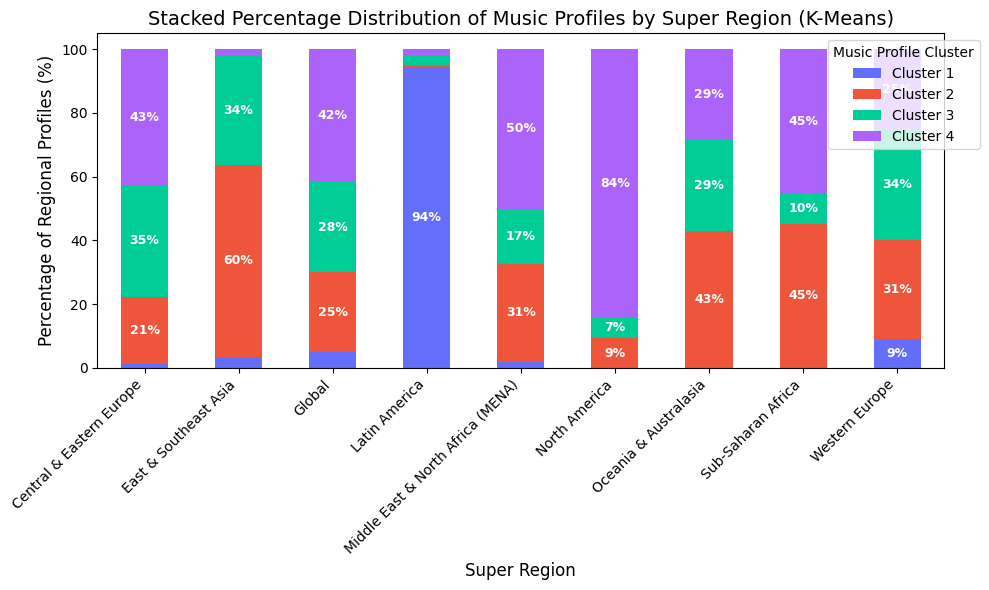

Saved Super Region Distribution plot to 'k-means_super_region_cluster_stacked_percentage.png'.

--------------------------------------------------
K-MEANS REGIONAL ANALYSIS RESULT HEADS
--------------------------------------------------

Merged Cluster Region (K-Means) Head:


region  song_type_cluster  count           super_region
0  Argentina                  0     59          Latin America
1  Argentina                  3      1          Latin America
2  Australia                  1     28  Oceania & Australasia
3  Australia                  2     17  Oceania & Australasia
4  Australia                  3     15  Oceania & Australasia

--------------------------------------------------
--- Raw Cluster Count Plot for All Countries (K-Means) ---


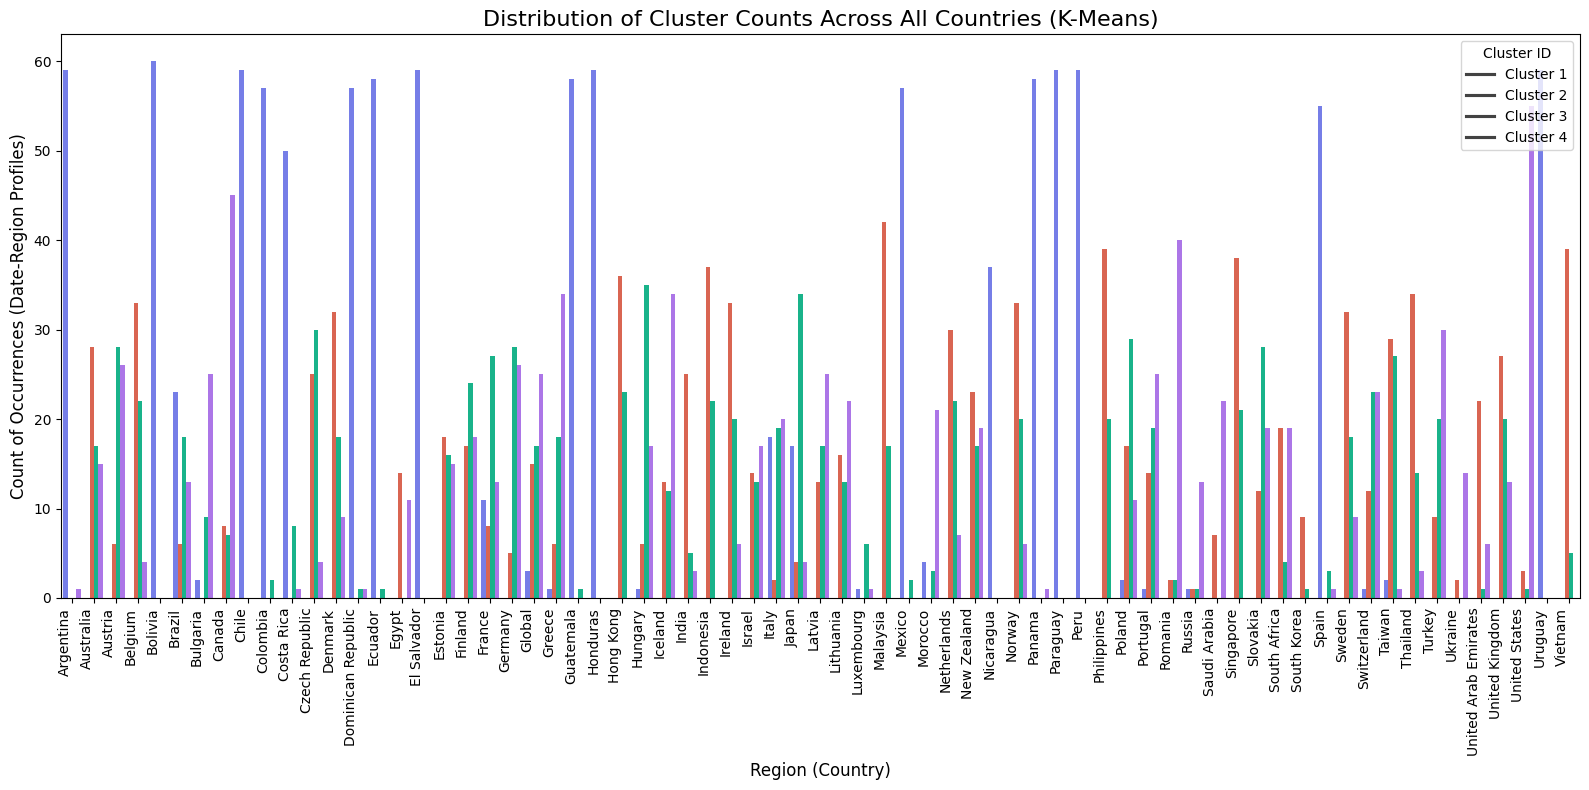

Saved country-level raw count plot to 'cluster_distribution_by_country_k-means.png'.
----------------------------------------
--- Country Percentage Distribution within Super Regions (K-Means) ---


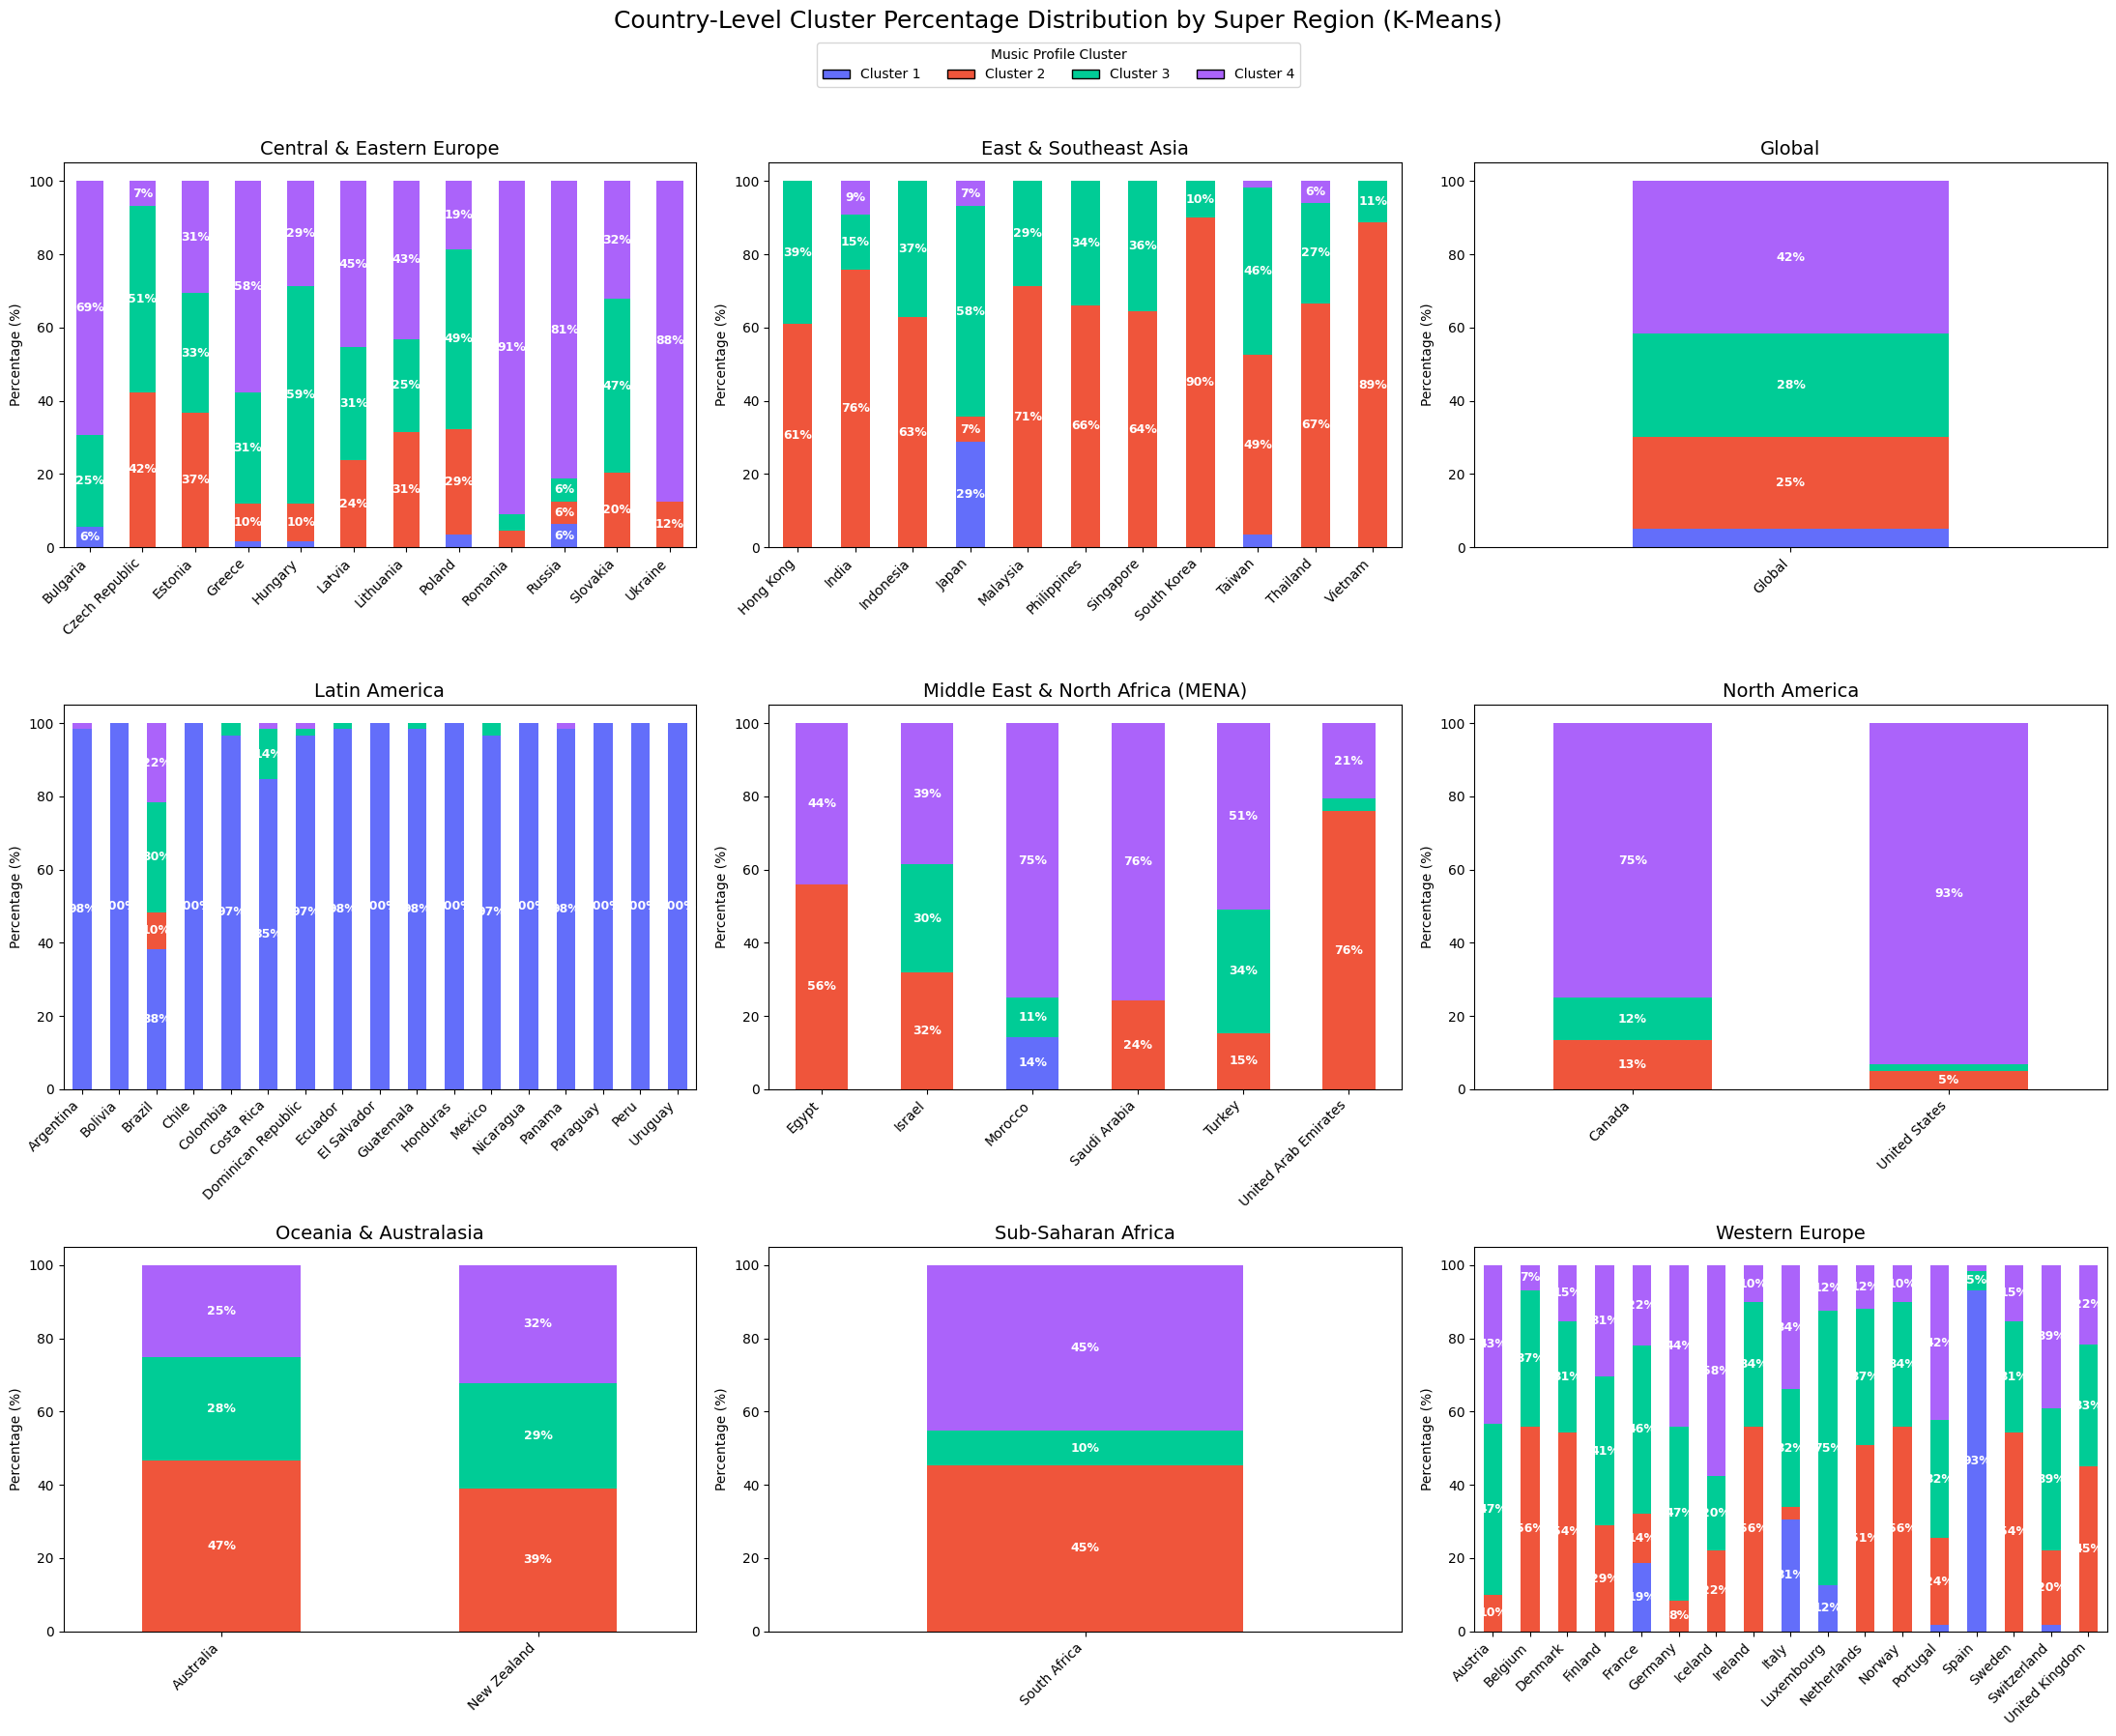

k-means_country_percentage_distribution_by_super_region.png
Finished plotting all super regions.
----------------------------------------
--------------------------------------------------
--- 7. Dominant Cluster Choropleth Map (K-Means) ---
Interactive map file created: dominant_cluster_world_map_k_means.html
----------------------------------------


/tmp/ipython-input-1157878556.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# =================================================================
# K-MEANS INTERPRETATION & ANALYSIS
# =================================================================

print("="*50)
print("K-MEANS INTERPRETATION & ANALYSIS")
print("="*50)

# 6. K-Means Regional Analysis and Map
merged_cluster_region_kmeans, cluster_counts_by_region_kmeans = analyze_regional_distribution(
  kmeans_profiles, "K-Means", CLUSTER_NAMES
)

print("\n" + "-"*50)
print("K-MEANS REGIONAL ANALYSIS RESULT HEADS")
print("-"*50)
print("\nMerged Cluster Region (K-Means) Head:")
display(merged_cluster_region_kmeans.head())
print("-" * 50)

# 7. Country-level Plots (K-Means)
plot_country_cluster_counts(merged_cluster_region_kmeans, "K-Means", CLUSTER_NAMES)
plot_country_percentage_by_super_region(merged_cluster_region_kmeans, "K-Means", CLUSTER_NAMES)

print("-" * 50)
generate_choropleth_map(cluster_counts_by_region_kmeans, "K-Means")

**Regional Distribution Analysis (K-Means)**

* **Super Regions**
  * Upon initial observation, it is quite apparent how dominant the blue cluster (Cluster 1) is in Latin America, taking 94% of the super-region's Music Profile. We know that this region is heavily shaped by Latin music, which -- if you have ever heard “Gasolina” by Daddy Yankee ft. Bad Bunny -- you’ll recognize has a very distinct music profile that is characterized by high danceability, loudness, valence, and energy. These characteristics closely mirror those which defined Cluster 1 during the initial K-Means process. Interestingly enough, Cluster 1 was the least listened to cluster at a global level. There is a notable spike in Western Europe (which we later see turns out to be the result of Spain's influence in Western Euopre and further reinforces the insight of inter-regional music differences). This distribution of this cluster suggests homogenity in music taste across the Latino parts of the world.

  * Similarly, North America is strongly dominated by Cluster 4 (84%). When we look back at the characteristics defining this cluster -- medium/high danceability, low/medium energy, high speechiness, medium/high acousticness, high instrumentalness, high liveness, low valence, low loudness, and medium tempo, it begins to make sense. North America loves its pop music in all its forms. Whether it’s the albums of Pure Pop Queens like Taylor Swift’s *The Life of a Showgirl*, Sabrina Carpenter’s *Short ’n Sweet*, and Tate McRae’s *So Close to What*; the pop–country crossover of Zach Bryan’s *Oklahoma Smokeshow*, Morgan Wallen’s *I’m the Problem*, and Megan Moroney’s *Tennessee Orange*; or the indie/singer-songwriter sad-pop of Alex Warren’s *Ordinary*, sombr’s *back to friends*, and Olivia Dean’s *Man I Need* -- we love our flavors of pop, and it shows.

  * The dominance of Cluster 2 in East & Southeast Asia is also relatively strong, though lower than our top two super-regions, sitting at about 60%. Cluster 2 was defined by low danceability, low energy, low/medium speechiness, medium/high acousticness, high instrumentalness, low/medium liveness, low valance, low loudness, low tempo. Upon first glance this may seen strange given the dominance of K-Pop in the region. However, when we break it down, it actually aligns quite well. Our descriptions of the cluster are based on relevance to each other. Therefore, this is saying that out of the four music profiles we found, these are the characteristics of Cluster 2. Knowing this, the profile actually begins to make sense, because K-Pop is a lot different than the flavors of pop that emerge out of North America. According to our research, K-Pop is more dense in its intstrumentation and instrumentational layers. It blends a lot of genre elements together and complexity in the song structure. Western pop tends to be more predictable and repetitive -- more "catchy". As a result, it doesn't quite fit into the same cluster. K-Pop is also more highly produced than normal pop, resulting it its low/medium liveness, rather than the high liveness of western pop. These differences are quite stark and make it a different music profile. Additionally, We would like to note out that traditiobnal music in this region of the world also tends to be highly instrumental and mellow, possibly also playing an influence in the profile for these areas. Another interesting point here is that unlike Latin America -- which aside from Brazil, all speak Spanish -- East and South East Asia have many different countries with different official languages. Yet, the music profile of the songs seems to transcend the language barriers.

  * While a much lower dominance, at 34%, Cluster 3 did have a hold over Western Europe. K-Means defined our Cluster 3 to have low/medium danceability, medium/high energy, medium/high speechiness, low acousticness, low/medium instrumentalness, low liveness, medium valence, high/medium loudness, medium tempo. This is a region that is has a huge EDM, Swedish House, and Techno liking. We see the characteristics of these genres present in the Music Profile. For example, EDM is very production heavy, as demonstrated by the low liveness. These songs are also quite high in energy and tempo, often being played at music festivals by DJ's like John Summit and Diplo. The danceability is lower, which many seem suprising. However, we must remember that we don't know how danceability was calculated by Spotify, since their API for song features is now deprecated to the public. We only have the values that were provided in the dataset prior to this. Danceability may have been calculated by ability to perform choreographed routines like on *Dancing With The Stars* rather than bopping around with your besties at the club. Thus, overall this cluster still strongly reflects the most popular genres of Western Europe.

  * While remaining regions (Central & Eastern Europe, Middle East & North Africa, Oceania & Australia, and Sub-Saharan Africa) did have a dominant cluster, they did not have one at the same level of dominance as these four regions. Most of the world contains a fairly even split among the Purple, Orange, and Green Clusters. This matches what we saw from the K-Means Clustering Visualizations through PCA and t-SNE, where there was slight overlap between these 3 clusters. It shows that the listening patterns of a lot of the world are heterogenous, and many countries are not dominanted strongly by a specific music profile cluster.

* **Sub-Regions**

  * From the sub-region graphs, we can see that the majority of countries within a sub-region follow same music profile pattern, while some variation.

  * However, there is a deviance from this typical pattern in Brazil within Latin America and Spain in Western Europe. All the Latin American countries are almost completely dominanted (> 90%) by Cluster 1. However, in Brazil, it only makes up (> 50%) of the country's music profile, with Cluster 3 and Cluster 2 making up the majority of the rest. This could be attributed to the fact that the rest of Latin America speaks Spanish and Brazil speaks Portuguese. Interestingly, we don't see this dominance of Cluster 1 occuring in Portugal. Therefore, it could be possible that the proximity of Brazil to South America has also influences its Music Profile, and thus suggests the idea geographical proximity to music can influence a country's own music profile. On the flipside of things, because Spain speaks Spanish and has a heavy Latin Culture, we see Cluster 2 dominant it at 93% while either not present or only in a very small minority in all the other Western European countries.


**Chloropleth Map**

  * We wanted to try and visualize this on a world map and were able to do so by importing in a interactive map through the plotly. The html file is provided in our Final Submission folder, and can be dowloaded for an interactive visualization. However, an image of it is provided below:
  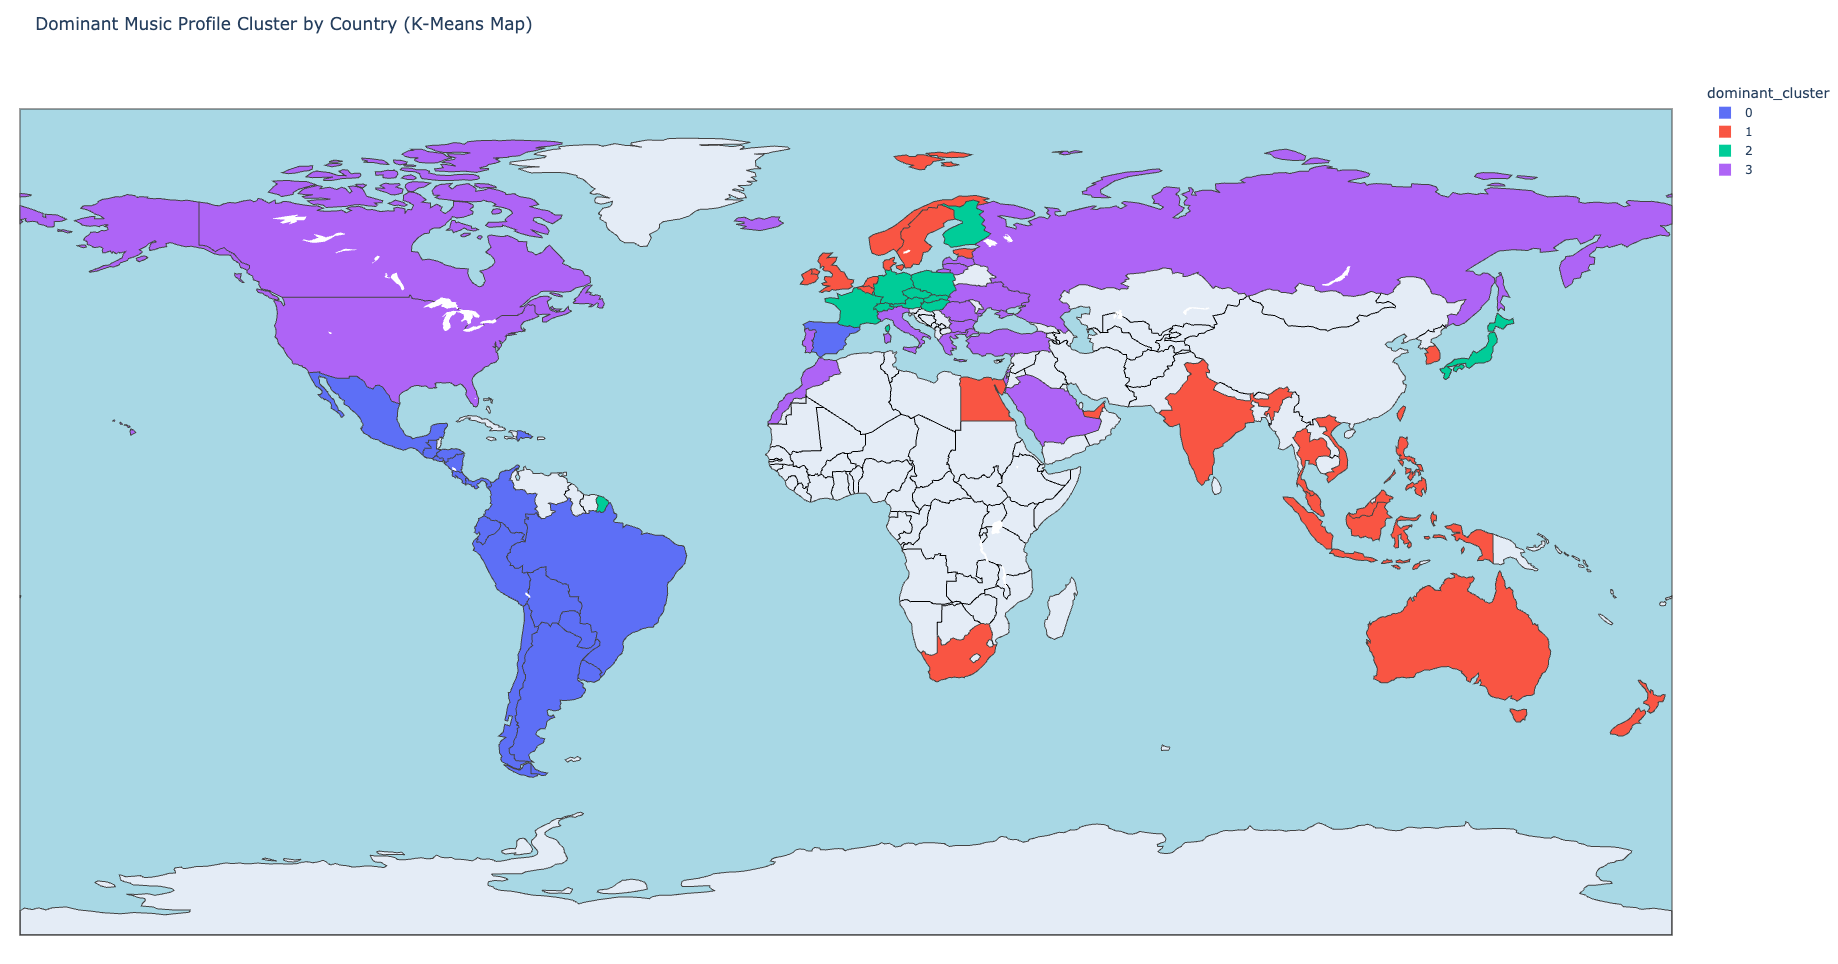


DBSCAN INTERPRETATION & ANALYSIS
--- 6. Regional Distribution Analysis (DBSCAN) ---


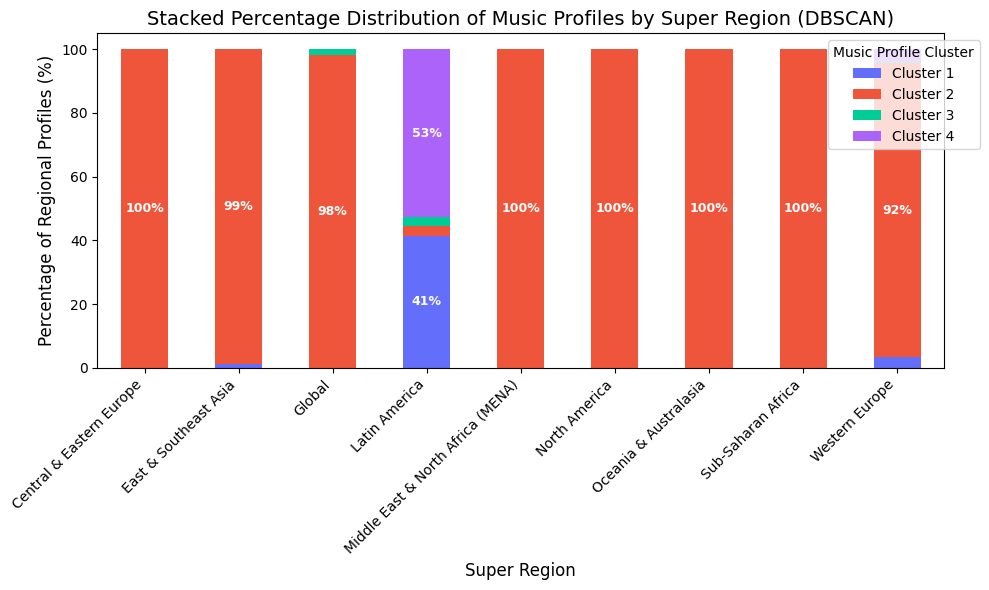

Saved Super Region Distribution plot to 'dbscan_super_region_cluster_stacked_percentage.png'.

DBSCAN REGIONAL ANALYSIS RESULT HEADS

Merged Cluster Region (DBSCAN) Head:


region  song_type_cluster  count           super_region
0  Argentina                  3     33          Latin America
1  Argentina                  0     27          Latin America
2  Australia                  1     60  Oceania & Australasia
3    Austria                  1     60         Western Europe
4    Belgium                  1     59         Western Europe

--------------------------------------------------
--- Raw Cluster Count Plot for All Countries (DBSCAN) ---


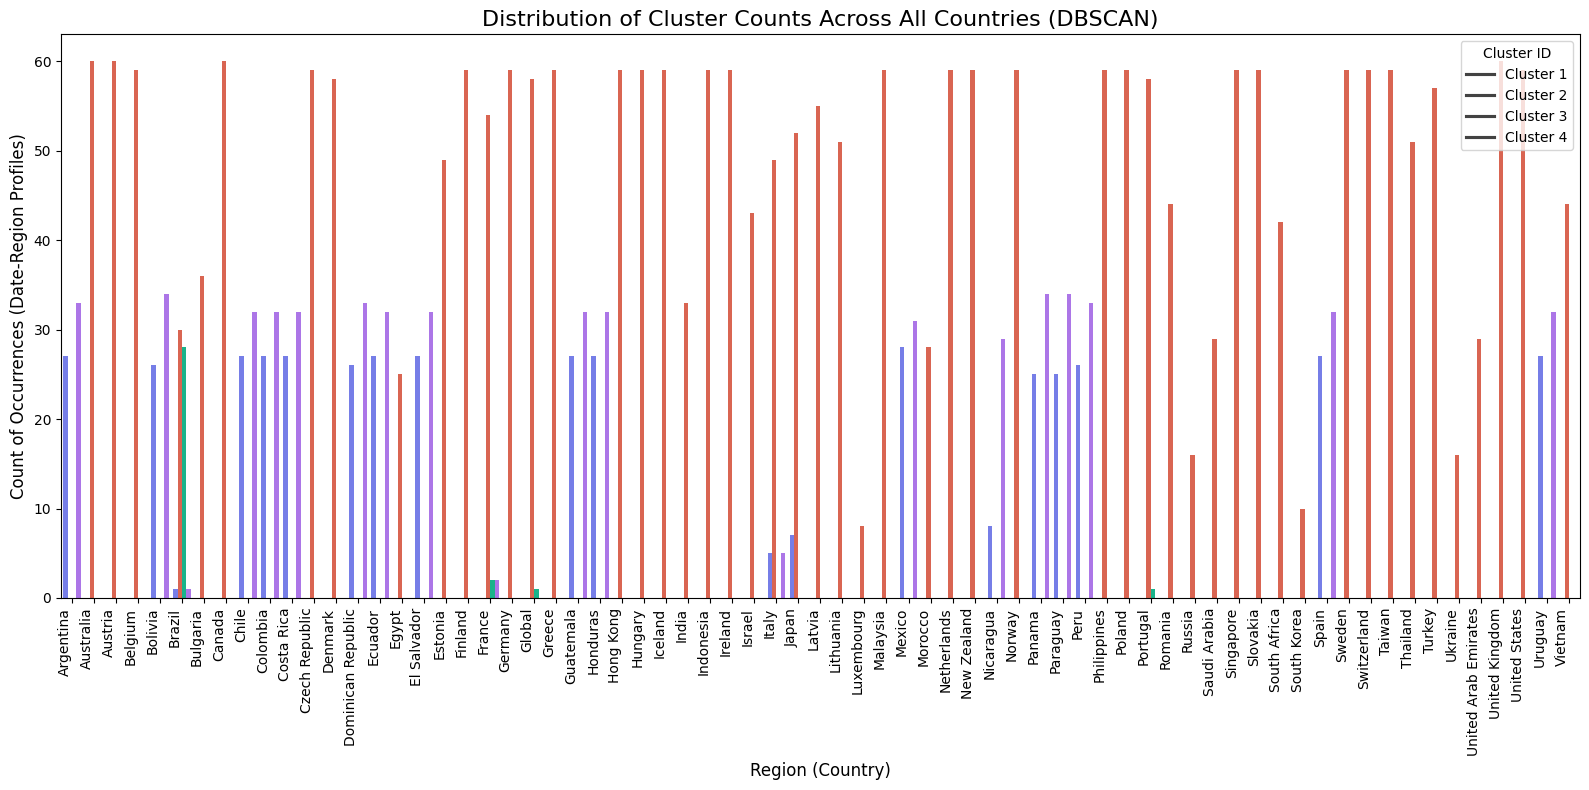

Saved country-level raw count plot to 'cluster_distribution_by_country_dbscan.png'.
----------------------------------------
--- Country Percentage Distribution within Super Regions (DBSCAN) ---


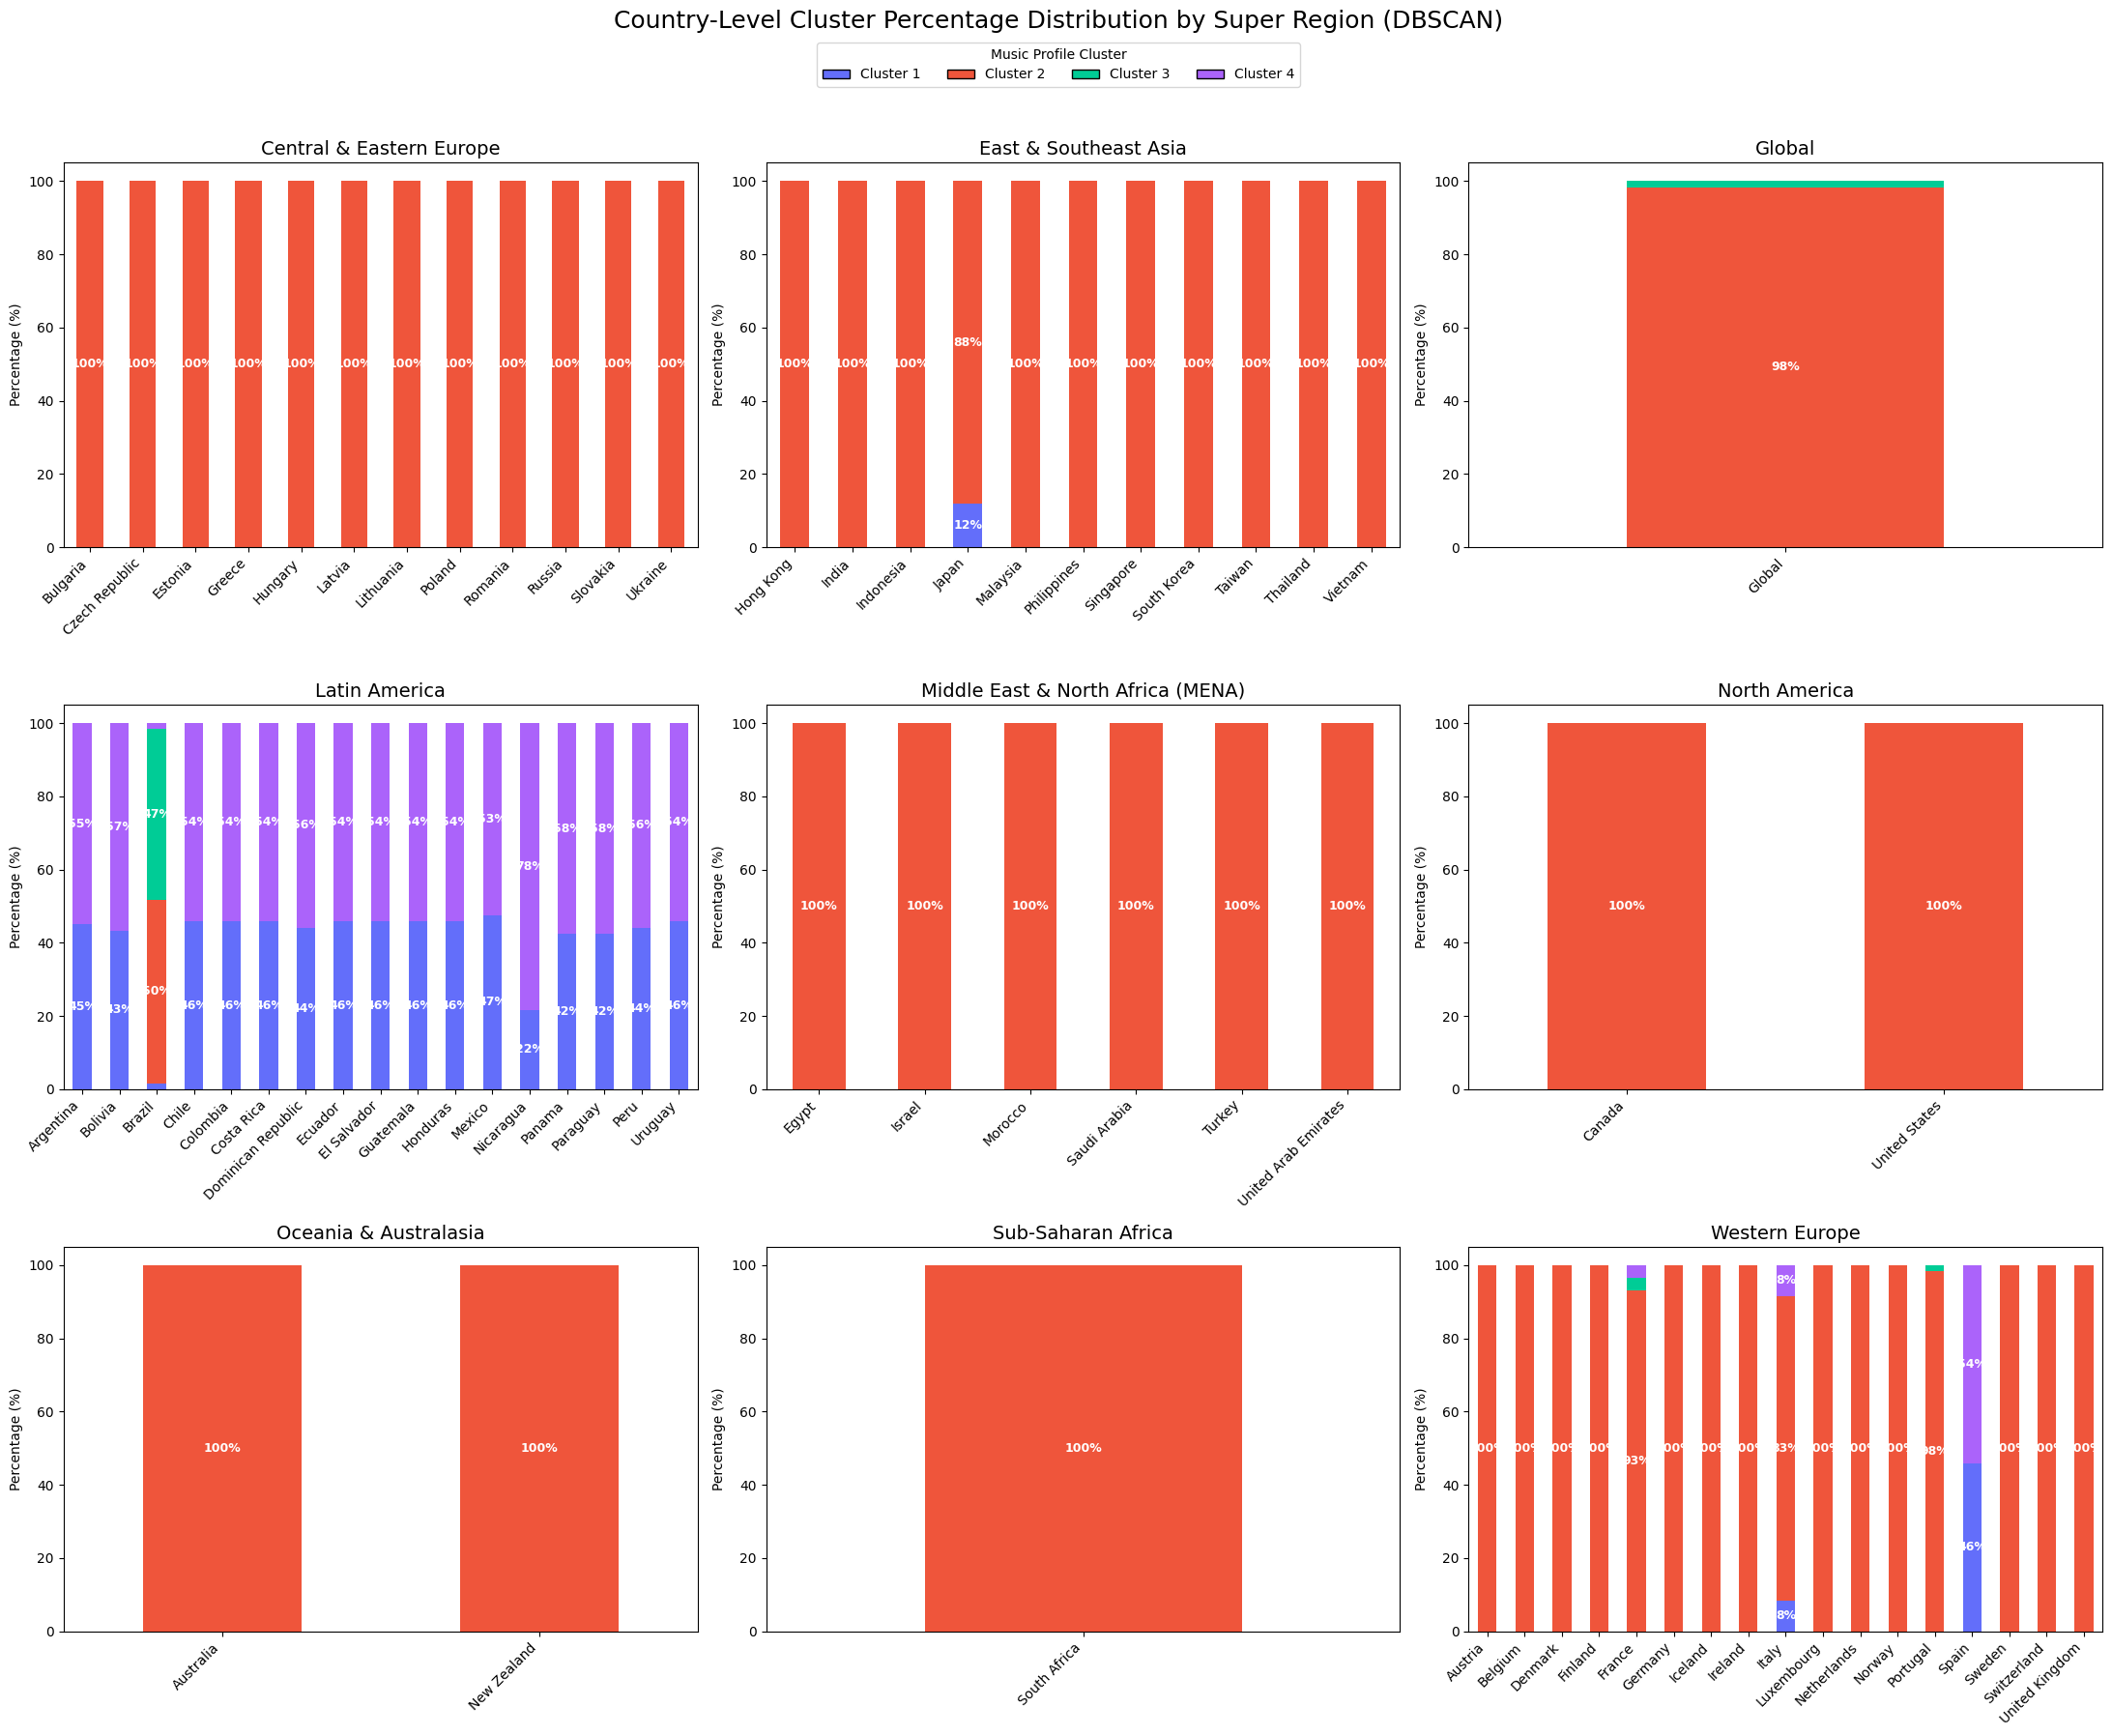

dbscan_country_percentage_distribution_by_super_region.png
Finished plotting all super regions.
----------------------------------------
--------------------------------------------------
--- 7. Dominant Cluster Choropleth Map (DBSCAN) ---
Interactive map file created: dominant_cluster_world_map_dbscan.html
----------------------------------------


/tmp/ipython-input-1157878556.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
print("\n" + "="*50)
print("DBSCAN INTERPRETATION & ANALYSIS")
print("="*50)

# 3. DBSCAN Regional Analysis and Map
merged_cluster_region_dbscan, cluster_counts_by_region_dbscan = analyze_regional_distribution(
  dbscan_profiles, "DBSCAN", CLUSTER_NAMES
)

print("\n" + "="*50)
print("DBSCAN REGIONAL ANALYSIS RESULT HEADS")
print("="*50)
print("\nMerged Cluster Region (DBSCAN) Head:")
display(merged_cluster_region_dbscan.head())
print("-" * 50)

# 4. Country-level Plots (DBSCAN)
plot_country_cluster_counts(merged_cluster_region_dbscan, "DBSCAN", CLUSTER_NAMES)
plot_country_percentage_by_super_region(merged_cluster_region_dbscan, "DBSCAN", CLUSTER_NAMES)

print("-" * 50)
generate_choropleth_map(cluster_counts_by_region_dbscan, "DBSCAN")

**Regional Distribution Analysis (DBSCAN)**

We conducted the same process as we did for K-Means interpretation for DBSCAN. However, it did not provide as great results as the inital clustering visualization.

*   The most glaring issue with this clustering is that while appearing distinct in the visualization, the orange supercluster is almost trivial. Almost every super region is dominated by this cluster, and there is no variance between the music in the regions. Latin America and Spain are the only places to not have a majority of this super cluster. This highlights the major musical profile difference of the music that is popular in these countries compared to the rest of the world. However, the DBSCAN clustering splits it into categories which could be interesting to explore.
* It is possible to maybe try breaking up this super cluster to yield distinct smaller clusters which better represent categories. However, our few attempts did not result in better sucess and thus, we decide to leave hyperparameter-tuning of this DBSCAN clustering to rest.
* As a result, we proceeded forward with the clusters generated by K-means for the temporal analysis.


STARTING TEMPORAL ANALYSIS BASED ON KMEANS MODEL CLASSIFICATION
Prediction successful! Full data shape: (384785, 15)


track_name  \
0      Chantaje (feat. Maluma)   
1  Vente Pa' Ca (feat. Maluma)   
2   Reggaetón Lento (Bailemos)   
3                       Safari   
4                  Shaky Shaky   

                                      artist_names       date     region  \
0                                  Shakira, Maluma 2017-01-01  Argentina   
1                             Ricky Martin, Maluma 2017-01-01  Argentina   
2                                             CNCO 2017-01-01  Argentina   
3  J Balvin, Pharrell Williams, BIA, Sky Rompiendo 2017-01-01  Argentina   
4                                     Daddy Yankee 2017-01-01  Argentina   

   rank  danceability  energy  speechiness  acousticness  instrumentalness  \
0     1         0.852   0.773       0.0776       0.18700          0.000030   
1     2         0.663   0.920       0.2260       0.00431          0.000017   
2     3         0.761   0.838       0.0502       0.40000          0.000000   
3     4         0.508   0.687       0.3260       0.55100          0.000003   
4     5         0.899   0.626       0.2920       0.07600          0.000000   

   liveness  valence  loudness    tempo  final_cluster_assignment  
0    0.1590    0.907    -2.921  102.034                         0  
1    0.1010    0.533    -4.070   99.935                         0  
2    0.1760    0.710    -3.073   93.974                         0  
3    0.1260    0.555    -4.361  180.044                         0  
4    0.0631    0.873    -4.228   88.007                         0


Super Region Trends Data Ready:


date              super_region  final_cluster_assignment  \
0 2017-01-01  Central & Eastern Europe                         0   
1 2017-01-01  Central & Eastern Europe                         1   
2 2017-01-01  Central & Eastern Europe                         2   
3 2017-01-01  Central & Eastern Europe                         3   
4 2017-01-01     East & Southeast Asia                         0   

   profile_count  percentage_of_chart  
0           8181            31.482337  
1           4901            18.860155  
2           8798            33.856692  
3           4106            15.800816  
4          20825            32.604271


--------------------------------------------------
Song Profile Clusters Popularity in the US over Time
--------------------------------------------------



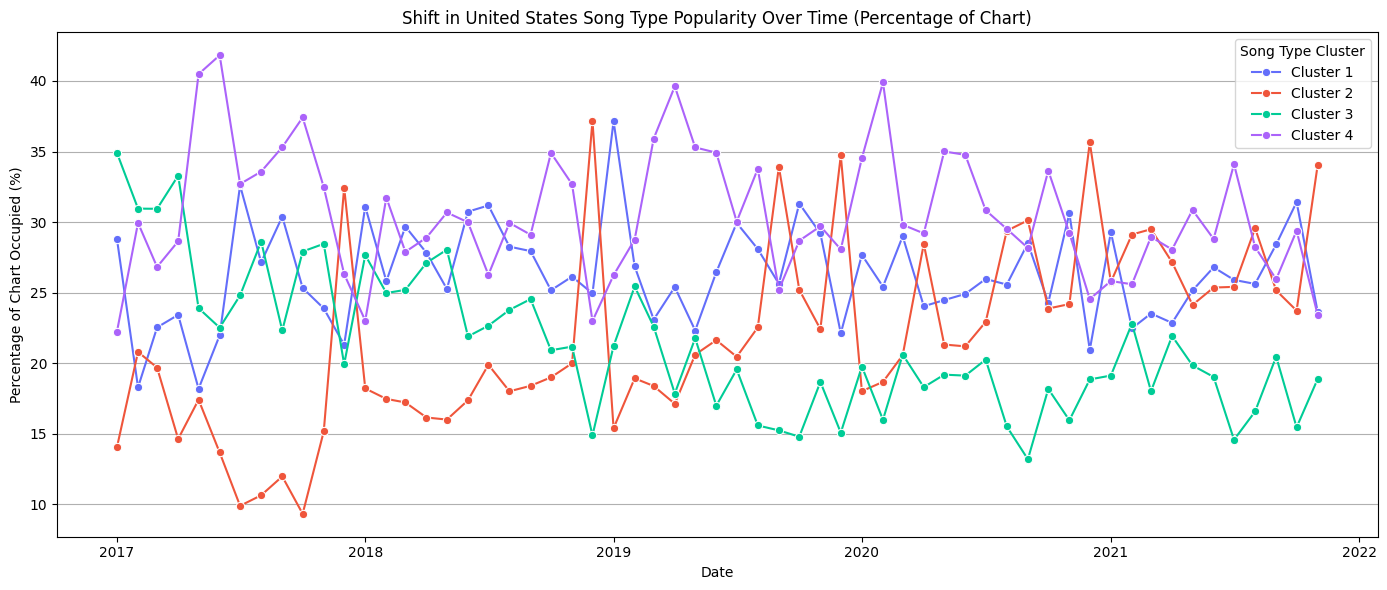

Saved temporal_trend_United_States.png

--------------------------------------------------
Song Profile Clusters Popularity in Each Super Regions over Time
--------------------------------------------------



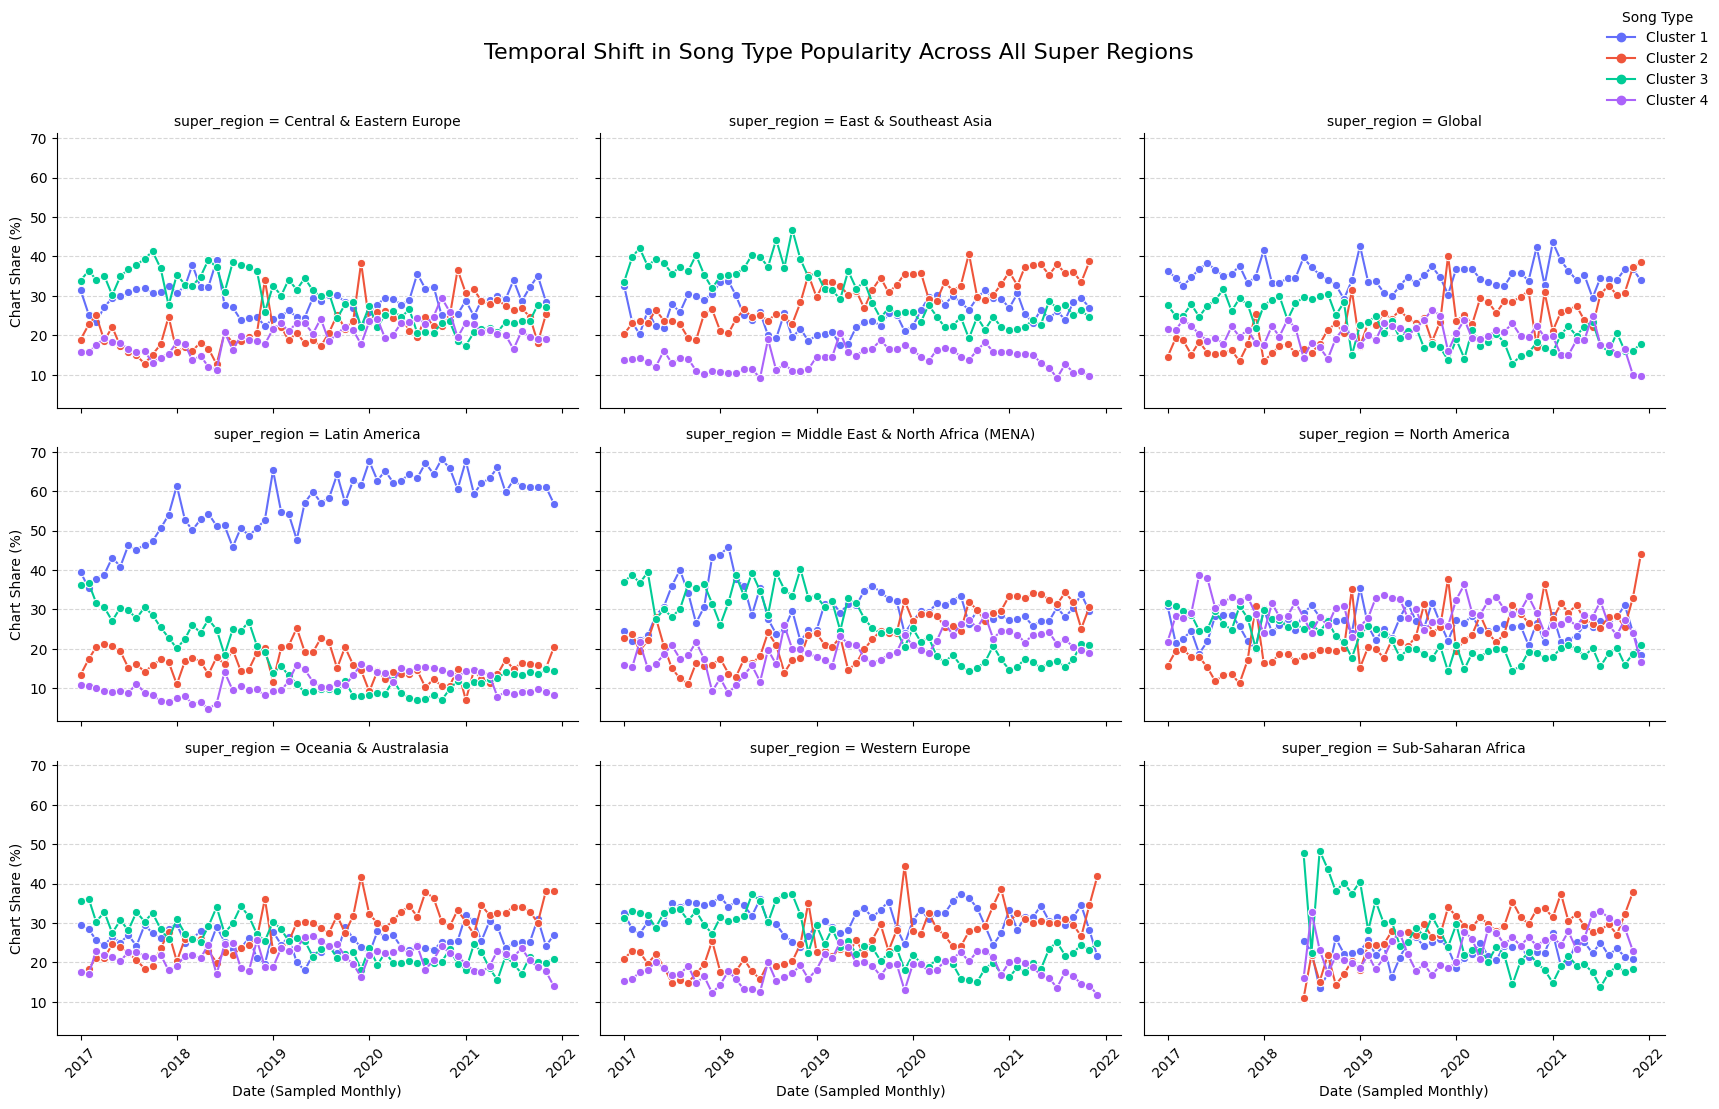

Saved all_regions_facet_plot.png

--------------------------------------------------
Song Profile Cluster Popularity Across Each Super Region over Time
--------------------------------------------------

--- Generating Temporal Trend Plots (2x2 Grid) ---


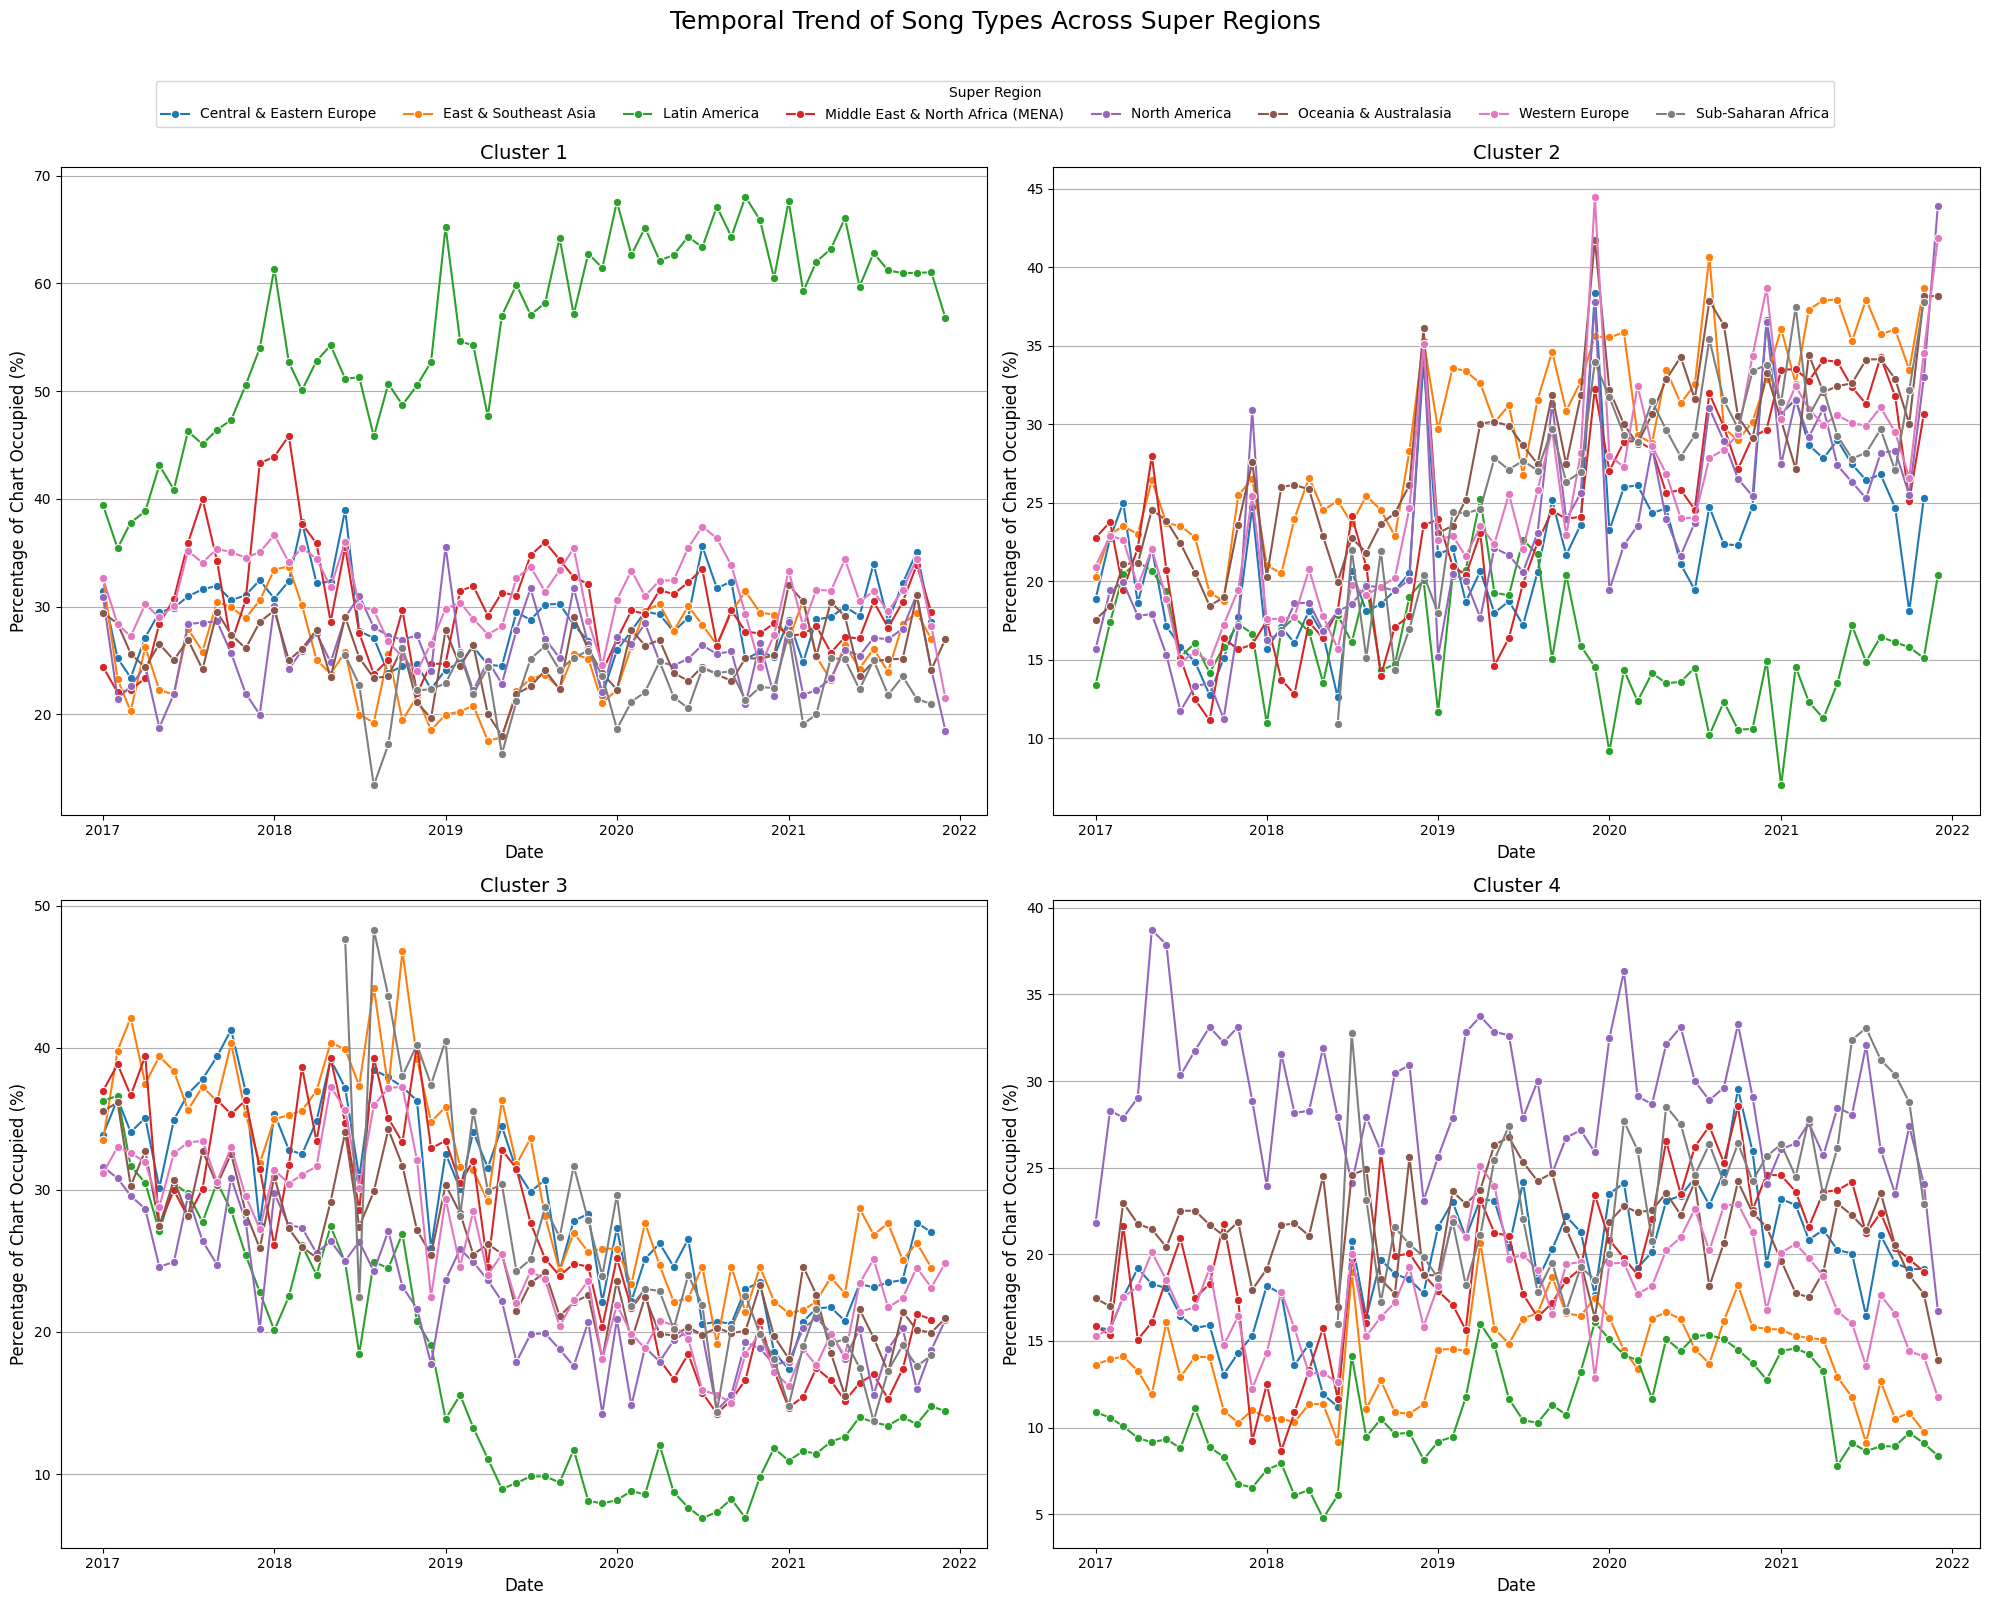

Generated plot: temporal_trend_grid_0.png
Finished generating all cluster trend grids.
----------------------------------------


In [ ]:
print("\n" + "="*50)
print("STARTING TEMPORAL ANALYSIS BASED ON KMEANS MODEL CLASSIFICATION")
print("="*50)

# 1. Prepare Data
final_temporal_report, super_region_trends = prepare_temporal_data(
  data_df=merged_df,
  feature_cols=FEATURE_COLS,
  model=kmeans_model,
  region_mapping=REGION_MAPPING_DICT
)

# 2. Plot: Single Region (e.g., United States)
print("\n" + "-"*50)
print("Song Profile Clusters Popularity in the US over Time")
print("-" * 50 + "\n")
plot_single_region_trend(
  temporal_report=final_temporal_report,
  region_name='United States',
  cluster_names=CLUSTER_NAMES
)

# 3. Plot: All Clusters Across All Super Regions (Facets)
print("\n" + "-"*50)
print("Song Profile Clusters Popularity in Each Super Regions over Time")
print("-" * 50 + "\n")
plot_all_regions_facet(
  super_region_trends=super_region_trends,
  cluster_names=CLUSTER_NAMES
)

# 4. Plot: Each Cluster Across All Super Regions
print("\n" + "-"*50)
print("Song Profile Cluster Popularity Across Each Super Region over Time")
print("-" * 50 + "\n")
plot_cluster_cross_region(
  super_region_trends=super_region_trends,
  cluster_names=CLUSTER_NAMES
)

**Temporal Cluster Analysis (K-Means)**

When we first ran our K-Means clustering, we did so using the aggregated dataset, which served as a representative sample of the larger merged dataset. Now that we have our K-Means model -- and have validated its regional music profiling as reasonably accurate -- we can extend its use by applying it to the full merged dataset to predict the musical profile of each individual song.

The results of this predictive modeling were visualized in two main ways. First, we created a graph for each sub-region, plotting the number of songs assigned to each cluster for every day from 2017 to 2021. This allowed us to observe how the popularity of different musical profiles shifted over time within each region. Second, we created a set of plots that flipped this perspective: for each cluster, we graphed all regions together. This let us examine whether certain clusters were consistently favored by particular regions, whether their popularity fluctuated, or whether any cyclical patterns emerged.

The key findings from these visualizations are presented below:

* All of the plots support the idea that Cluster 3 (Green) was popular from 2017-2018 but experienced a sharp decline at the beginning of 2019. In the US, and in every super region this cluster's chart share decreased. While our previous charts showed that the green cluster is one that spans multiple regions, this analysis proved that it also declined at a global scale.

* Once again Cluster 1 (Blue) dominates in Latin America. It actually grew more popular as time progressed showing increased levels of engagement in the music of their cultures. The final plots show that every other cluster declined as a result of cluster 1's dominance over time in Latin America.

* The music profile of Cluster 2 (Orange) increased in chart share from 2017-2021 suggesting a global shift to the music profile of this cluster. In East and South East Asia where it was shown to be dominant, it didn't reach that level of dominance until 2020. It's increase in popularity matches with the green cluster's decline around 2019-2020. This further asserts that there is a global shift from the green to orange music profiles which maintained its popularity throughout 2021.

* Cluster 4 (Purple) had the most unique temporal behavior. The popularity did not really change across the years outside of the natural ups and downs which affected the cluster's performance across every region. This likely indicates that this cluster has remained as popular in 2021 as it was in 2017. Since this was the cluster that we associated with all pop flavors, this makes sense. It is likely to be the most robust to temporal changes that result in shifts that lean into country or rock or anything else as long as they retain that pop foundation.

ITEM2VEC INTERPRETATION & ANALYSIS
Calculating cultural shift indices for all super regions...


/tmp/ipython-input-188059373.py:11: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



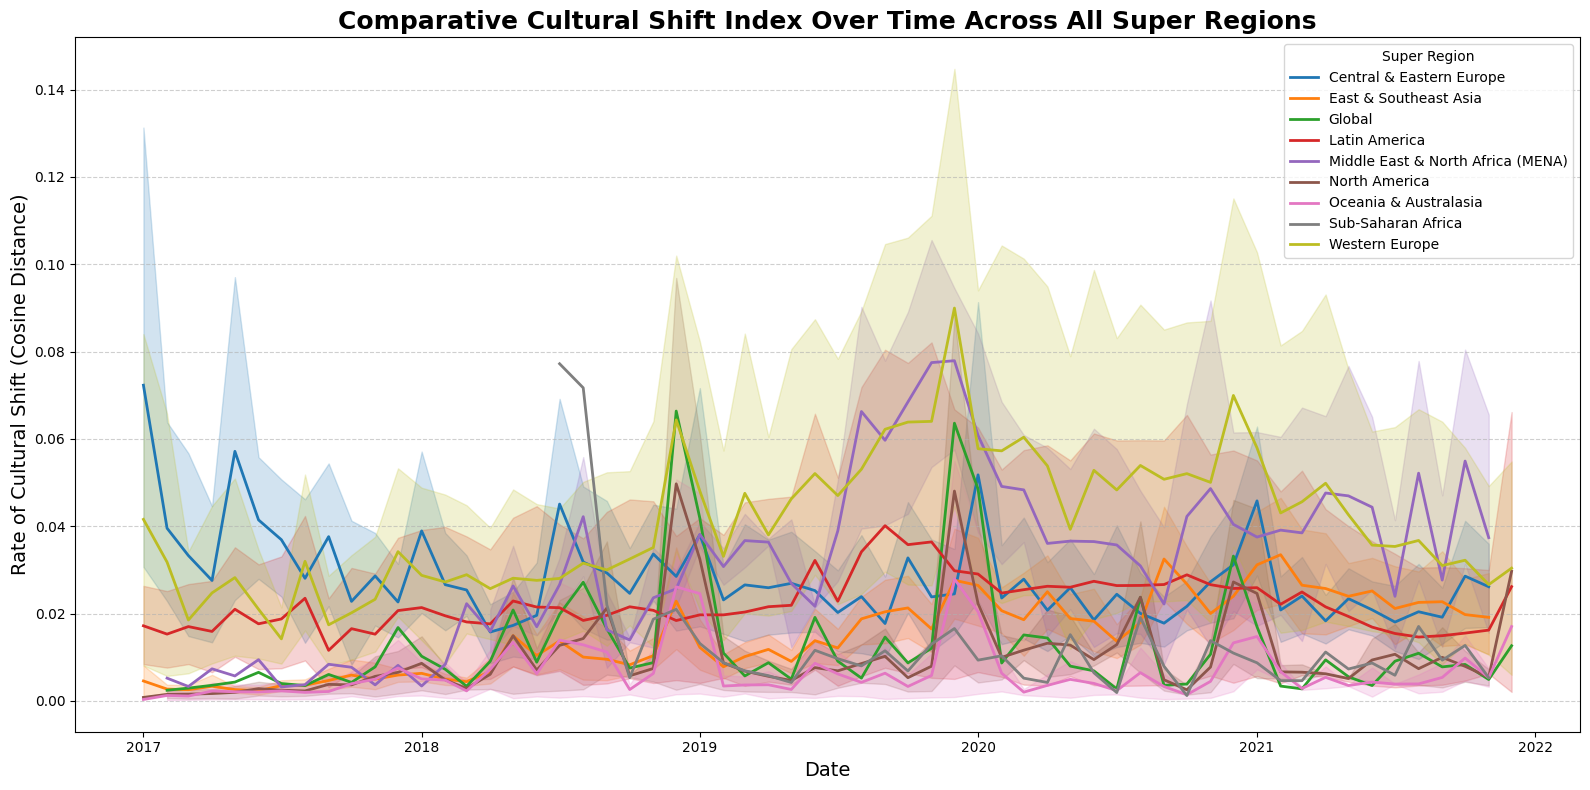

---------------------------------------------------------------------------
Comparative Culture Shift Index Over Time in Each Sub-Region
---------------------------------------------------------------------------


/tmp/ipython-input-1144469968.py:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



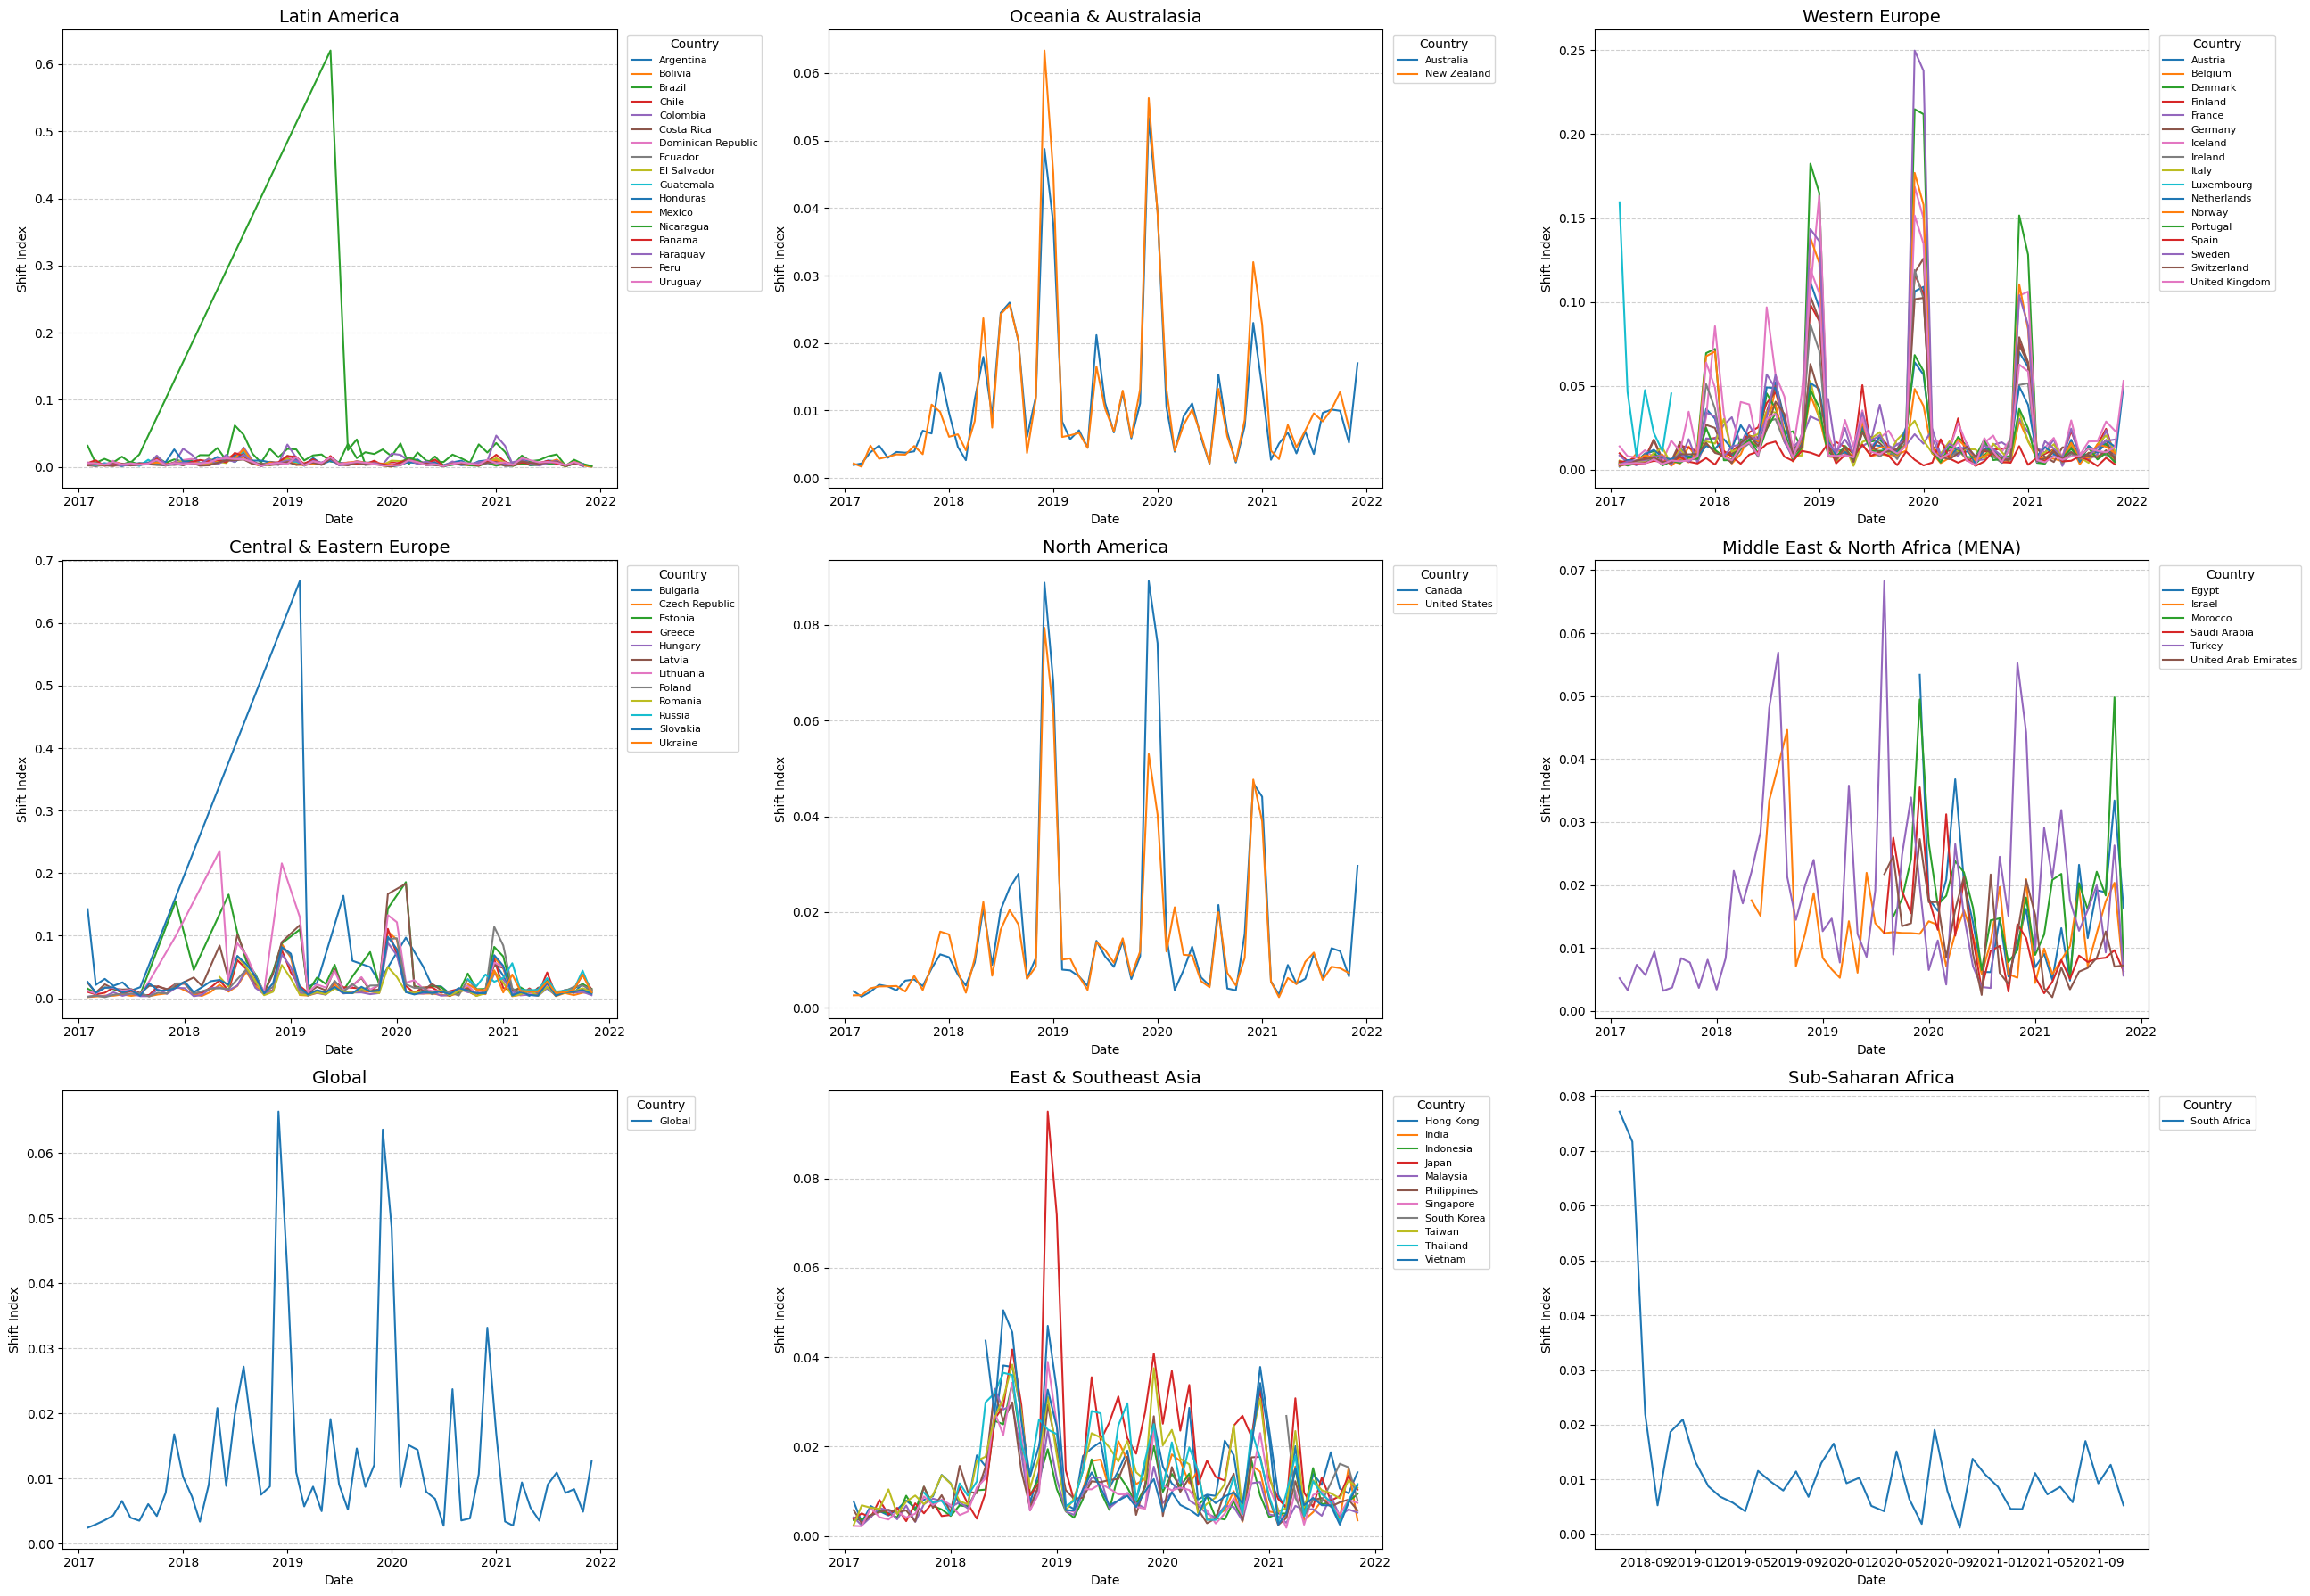

Saved all_super_regions_plot.png


In [ ]:
# =================================================================
# ITEM2VEC INTERPRETATION & ANALYSIS
# =================================================================
print("="*50)
print("ITEM2VEC INTERPRETATION & ANALYSIS")
print("="*50)
print("Calculating cultural shift indices for all super regions...")

all_super_region_shifts = (
    cultural_shift_df.groupby('super_region', group_keys=False)
    .apply(
        lambda group: calculate_regional_shift(
            group,
            EMBEDDING_COLS
        )
    )
    .reset_index(drop=True)
)

plot_comparative_time_series(all_super_region_shifts)

print('-' * 75)
print('Comparative Culture Shift Index Over Time in Each Sub-Region')
print('-' * 75)

country_shifts_df = calculate_all_country_shifts(cultural_shift_df, EMBEDDING_COLS)

region_map_rows = []

for super_region, countries in REGION_MAPPING_DICT.items():
    for country in countries:
        region_map_rows.append({
            "region": country,
            "super_region": super_region
        })

region_map_df = pd.DataFrame(region_map_rows)

country_shifts_df = pd.merge(
    country_shifts_df,
    region_map_df,
    on='region',
    how='left'
)

plot_all_super_regions(country_shifts_df)

**Cultural Shift Analysis (Item2Vec)**

While the above temporal analysis told us how popularity of different music profiles changed over time across and within regions, it didn't give us insight into how the overall culture (sentiment) of the Top 200 songs changed over time. For this, we applied the embeddings that were created using the Song2Vec model to calculate and visualization the cultural shift in Top 200 songs over time for all the different regions.

Siumilar to the K-Means temporal analysis, two visualizations were produced. The first graph plotted all super-regions together to understand whether these cultural shifts occur at the same rate and time in different parts of the world or if it differs. From the plot, you can see that the overall plot for each super-region follows the same pattern, indicating that most cultural shifts in music are global. There is variation to the rate and the time at which some of the smaller shifts occur, but the overarching pattern is clear.

  * This dominant shift across the charts is the yearly spikes in December. This is likely due to Christmas music storming up the charts at this time of year with its temporal nature and distinct musical profile.

Additionally, we went on to plot each of the sub-regions and the countries within them individually. This was done to gain insight into whether or not there may be different shifts within a region. For the most part, these were also similar and consistent patterns. However, there were a few anomalies:

  * From 2019 onwards, Western Europe consistently had the highest cultural rate of change (Also the highest peaks showing the most volatility). This also could be due to the nature of Western Europe having many distinct cultures across its various countries. In the clustering analysis Western Europe was the most diverse super region by cluster. This indicates that overtime shift in music taste has become quicker.

  * The data in Latin America once again shows its cultural dominance to the latino music. The rate of change is minimal, which was reflected in the how cluster 1 (blue) was dominant the entire timeframe. However, Brazil is the one country that doesn't follow the same rate of change, and this is likely due to their Porteguese roots. Showing that there is musical cultural difference despite the geographical proximity.

## **Step 4. Statistical & Comparative Analysis**
---
This step focuses on comparing the two clustering algorithms (K-Means and DBSCAN) and evaluating the statistical significance of the identified clusters to determine the validity of the audio features. It involves:
*   **Clustering Algorithm Comparison**: Comparing the cluster assignments of K-Means and DBSCAN using contingency tables.
*   **Statistical Significance Testing**: Performing ANOVA tests on audio features to assess if there are statistically significant differences between the cluster means.

In [ ]:
def compare_cluster_assignments(kmeans_profiles, dbscan_profiles):
    """Compares the cluster assignments of K-Means and DBSCAN using a contingency table."""
    print("--- 8. Cluster Assignment Comparison (K-Means vs. DBSCAN) ---")

    # Ensure both dataframes align perfectly on index (date, region)
    comparison_df = pd.DataFrame({
        'KMeans_Cluster': kmeans_profiles['song_type_cluster'],
        'DBSCAN_Cluster': dbscan_profiles['song_type_cluster']
    })

    # Create the contingency table (cross-tabulation)
    contingency_table = pd.crosstab(
        comparison_df['KMeans_Cluster'],
        comparison_df['DBSCAN_Cluster'],
        rownames=['K-Means Cluster'],
        colnames=['DBSCAN Cluster (includes -1 for Noise)'],
        margins=True, # Add row/column totals
        dropna=False
    )

    print("Contingency Table of Cluster Assignments:")
    print("Rows = K-Means Clusters, Columns = DBSCAN Clusters (-1 is Noise/Outlier)")
    display(contingency_table)
    print("-" * 40)

    return contingency_table

In [ ]:
def run_anova_tests(df_profiles, method_name, alpha=0.05):
    """
    Performs one-way ANOVA for each feature to see if cluster means differ.
    Returns list of features where the difference is statistically significant.
    """
    print(f"\n--- 9. ANOVA Test Results ({method_name}) ---")

    # Filter out the noise cluster (-1) for DBSCAN before testing
    if method_name == 'DBSCAN':
        df_profiles = df_profiles[df_profiles['song_type_cluster'] != -1].copy()

    significant_features = []
    anova_results = {}

    for feature in FEATURE_COLS:
        # Group data by cluster for ANOVA
        groups = [df_profiles[df_profiles['song_type_cluster'] == c][feature]
                  for c in df_profiles['song_type_cluster'].unique()]

        # Check that there is more than one group and all groups are non-empty
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            f_statistic, p_value = stats.f_oneway(*groups)
        else:
            f_statistic, p_value = np.nan, 1.0 # Cannot run ANOVA

        anova_results[feature] = {'F': f_statistic, 'p': p_value}

        if p_value < alpha:
            significant_features.append(feature)

    results_df = pd.DataFrame.from_dict(anova_results, orient='index')
    results_df.index.name = 'Audio Feature'
    results_df['Significant'] = results_df['p'] < alpha
    results_df = results_df.sort_values(by='p')

    print(f"Overall ANOVA (Alpha={alpha}):")
    display(results_df)

    if not significant_features:
        print("No audio features showed a statistically significant difference across clusters.")
    else:
        print(f"\nFeatures with statistically significant cluster means: {', '.join(significant_features)}")

    print("-" * 40)
    return significant_features

In [ ]:
# =================================================================
# CLUSTERING ALGORITHM COMPARISON
# =================================================================
print("="*50)
print("CLUSTERING ALGORITHM COMPARISON")
print("="*50)

compare_cluster_assignments(kmeans_profiles, dbscan_profiles)

# =================================================================
# CLUSTERING STATISTICAL SIGNIFICANCE
# =================================================================
print("\n" + "="*50)
print("CLUSTERING STATISTICAL SIGNIFICANCE")
print("="*50)

significant_features_kmeans = run_anova_tests(kmeans_profiles, "K-Means")

significant_features_dbscan = run_anova_tests(dbscan_profiles, "DBSCAN")

CLUSTERING ALGORITHM COMPARISON
--- 8. Cluster Assignment Comparison (K-Means vs. DBSCAN) ---
Contingency Table of Cluster Assignments:
Rows = K-Means Clusters, Columns = DBSCAN Clusters (-1 is Noise/Outlier)


DBSCAN Cluster (includes -1 for Noise)  -1    0     1   2    3   All
K-Means Cluster                                                     
0                                        0  426    47  23  552  1048
1                                        4    0   907   4    0   915
2                                        1   21   827   0    0   849
3                                        1    0   782   5    5   793
All                                      6  447  2563  32  557  3605

----------------------------------------

CLUSTERING STATISTICAL SIGNIFICANCE

--- 9. ANOVA Test Results (K-Means) ---
Overall ANOVA (Alpha=0.05):


F              p  Significant
Audio Feature                                            
danceability      2117.132373   0.000000e+00         True
energy            2541.382516   0.000000e+00         True
acousticness      1168.523945   0.000000e+00         True
loudness          3445.658004   0.000000e+00         True
valence           3353.975522   0.000000e+00         True
speechiness        521.421660  2.176314e-281         True
liveness           460.485685  3.123890e-253         True
instrumentalness   413.443526  8.824627e-231         True
tempo              348.501853  1.084910e-198         True


Features with statistically significant cluster means: danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence, loudness, tempo
----------------------------------------

--- 9. ANOVA Test Results (DBSCAN) ---
Overall ANOVA (Alpha=0.05):


F              p  Significant
Audio Feature                                            
danceability      1434.751899   0.000000e+00         True
energy            1172.747340   0.000000e+00         True
valence           3562.492654   0.000000e+00         True
loudness          1818.460244   0.000000e+00         True
tempo              583.340272  6.567345e-309         True
speechiness        395.662962  4.467214e-222         True
liveness           179.219399  2.716960e-108         True
instrumentalness   170.652692  1.970886e-103         True
acousticness        83.005176   6.379987e-52         True


Features with statistically significant cluster means: danceability, energy, speechiness, acousticness, instrumentalness, liveness, valence, loudness, tempo
----------------------------------------


From the ANOVA tests above, we can see that the p-value for each of the nine audio features was below the significance threshold of 0.05. This indicates that every feature varied significantly across the clusters, meaning both our K-Means and DBSCAN models successfully identified groups that are meaningfully distinct from one another. This is critical because it demonstrates that the musical profiles produced by the clustering process were not the result of random variation or superficial noise in the dataset. Instead, the clusters capture underlying structural differences in how songs behave across the audio-feature space.

This means that the music profiles found are statistically validated patterns within the data. It provides us with stronger confidence that the cluster assignments that resulted from K-Means Clustering and the K-Means Model Prediction reflect real musical differences that separate one group of songs from another. It allowed us to interpret these clusters not just as data points, but as real representationss of distinct musical genres and listening preferences across regions and time periods.

## **Conclusion**
---
In this project, our intent was to uncover whether meaningful patterns in global music consumption could be identified through audio-feature clustering and regional analysis. By aggregating five years of Spotify Top-200 data across dozens of countries and compressing daily charts into representative monthly audio-feature vectors, we were able to reveal distinct “music profiles” that consistently appear across countries and over time.

These patterns have practical implications for both artists and streaming platforms. Artists and labels can use regional audio-feature trends as a form of market analysis to identify where their songs are most likely to resonate. By identifying regions with emerging popularity for certain musical profiles and adjusting release strategies or promotional efforts accordingly, they can improve their music’s reception. Also, our findings help explain why Spotify’s recommendation engine is so effective. When two tracks share similar audio feature characteristics, they naturally cluster together which enables Spotify to recommend new music that aligns closely with a listener’s past preferences. This feature-driven similarity is the foundation behind their successful recommendation system, and our analysis provides a clearer understanding of the patterns that make those recommendations feel intuitive and personalized.